# Cel projektu/The project's goal.

Projekt ten realizuje zadania związane z przetwarzaniem języka naturalnego (NLP) dla stosunkowo krótkich (300-600 znaków) piosenek ze zbioru "spotify_millsongdata" (adres strony internetowej podany w notebooku stworzonym dla zbudowania zbioru danych). Po wstępnym przetworzeniu rekordy ze zbioru zostaną poddane działaniu modeli opartych na algorytmie BERT; w pierwszym kroku sprawdzę nacechowanie emocjonalne piosenek wg klasyfikacji Ekmana (sześć podstawowych emocji + neutralne nacechowanie), w drugim zaś sprawdzę sentyment pozytywny i negatywny piosenek oraz przypiszę im klasę wg przeważającego sentymentu. Po zatykietowaniu danych i nadaniu im wartości ciągłych (z przedziału 0-1, nacechowanie poszczególnymi emocjami jest znormalizowane) podejmę się wizualizacji danych przede wszystkim pod kątem występowania różnych wartości ze względu na klasę, a na samym końcu (po przetworzeniu tekstu celem jego dalszego przetwarzania) spróbuję sprawdzić, czy tradycyjne metody uczenia maszynowego (oparte na twierdzeniu Bayesa, drzewo decyzyjne i algorytm K-najbliższych sąsiadów) są w stanie osiągnąć podobny poziom skuteczności w rozumieniu tekstu, co zaawansowane modele uczenia głębokiego.
_________________________

This project aims to tackle natural language processing (NLP) tasks for relatively short (300-600 characters) songs from the "spotify_millsongdata" dataset (website address provided in the notebook created to build the dataset). After initial preprocessing, the records from the dataset will be processed using models based on the BERT algorithm. In the first step, I will assess the emotional valence of the songs according to Ekman's classification (six basic emotions plus neutral valence). In the second step, I will determine the positive and negative sentiment of the songs and assign them a class based on the prevailing sentiment. After labeling the data and assigning continuous values to them (ranging from 0 to 1, with emotional valence normalized), I will proceed with visualizing the data, primarily focusing on the occurrence of different values with respect to the class. Finally, after processing the text for further analysis, I will attempt to determine if traditional machine learning methods (based on Bayes' theorem, decision trees, and the k-nearest neighbors algorithm) can achieve a similar level of effectiveness in text understanding as advanced deep learning models.

# Import bibliotek/Import of libraries.

Zaczniemy od zaimportowania wszystkich bibliotek i algorytmów potrzebnych nam do dalszej pracy z danymi. Za pomocą linijek **warnings.filterwarnings("ignore")** i **pd.set_option("display.max_colwidth", -1)** sprawimy odpowiednio, że output kodu nie będzie wyświetlać ostrzeżeń oraz że wyświetlając ramkę danych będziemy widzieć pełną zawartość komórek.
_____________
Let's start by importing all the necessary libraries and algorithms for our data processing. Using the lines **warnings.filterwarnings("ignore")** and **pd.set_option("display.max_colwidth", -1)**, we will suppress warnings in the code output and ensure that the full content of cells is displayed when viewing a DataFrame.

In [1]:
import pandas as pd
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", -1)

# Załadowanie zbioru danych i jego wstępne przetworzenie/Loading and initial processing of dataset.

Załadujmy opracowany przez nas zbiór danych (o jakże oryginalnej nazwie **songs.csv**) i przypiszmy go do zmiennej **df**.
________
Let's load our developed dataset (with the oh-so-original name **songs.csv**) and assign it to the variable **df**.

In [2]:
url = 'https://raw.githubusercontent.com/jakubtwalczak/songs_sentiment_bert_labeled/main/songs.csv'

df = pd.read_csv(url, encoding='utf-8')
df.sample(5)

,text,artist
2688,I'm not so bulletproof \nBut this is something \nI could never say to you \nThis sometimes buries me \nAnd I don't know if this is someone I can be \n \nI tell myself it's right \nStill feels so wrong \n \nIt's better than nothing \nI'd rather not be here all by myself \nIt's better than nothing here with someone else \nIt's better than nothing \nI'd rather not be standing here alone \nIt's better than feeling like you're on your own \n \nI'm not so culpable \nI never meant for this to get out of control\n\n,Face To Face
1646,The Beatles are dead. \nAndy Warhol's shit she said. Yeah. \nReactor reactor reactor. \nGive me a better foot in time. \nIn luxury. in love. \nPeople said he left her for another woman. \nBut she knew he left her for another car. \nA velvet craft. \nWe slide in shaking in the hole \nResting beneath the ground. \nBetween the sun is cracks. \nIt breaks above our heads. \nHoly water hoses the whole school \nWhite porcelain against my face \nSquatting discreet and shitless concealed.\n\n,Underworld
3162,"In your easter bonnet, with all the frills upon it, \nYou'll be the grandest lady in the easter parade. \nI'll be all in clover and when they look you over, \nI'll be the proudest fellow in the easter parade. \nOn the avenue, fifth avenue, the photographers will snap us, \nAnd you'll find that you're in the rotogravure. \nOh, I could write a sonnet about your easter bonnet, \nAnd of the girl I'm taking to the easter parade.\n\n",Irving Berlin
964,All I give \nIs all I got \nAnd all I am \nAin't what I'm not \nAnd I ain't gonna lie or beg \nFor your love \nI'm on a natural high \n \nWhen morning comes \nTake my hand \nTo free your mind \nCome to my land \nBut I ain't gonna lie or beg \nFor your love \nI'm on a natural high \n \nAnd I don't require no service \nAnd I'll make sweet love to you \nEvery day and night \nI live my life for you \nI'm on a natural high \n \nAll I give \nIs all I got \nAnd all I am \nAin't what I'm not \nAnd I ain't gonna lie or beg \nFor your love \nI'm on a natural high\n\n,Lenny Kravitz
4679,"Does it matter if you broke this spell \nSo unreal is the future life along the way \nThey dare you \nTo turn around, it all comes through this feel \nIt doesn't ring true \n \nSilent talking in the system, ringing to this beautiful world \nSilent talking, always dreaming, sing me to this beautiful world \nSilent talking in the system, ringing to this beautiful world \nSilent talking, always dreaming, sing me to this beautiful world \n\n",Yes


Zbiór zawiera 4718 wartości niepustych (**non-null**). Jak dobrze pamiętamy z notebooka **songs_sentiment_bert_labeled - building dataset**, właśnie tyle rekordów udało się wydobyć z pierwotnego zbioru, co oznaczać, że dane nie zawierają wartości NaN. Powyższą obserwację potwierdza stworzony wykres typu **displot**.
__________

The dataset contains 4718 non-null values. As we remember from the notebook **songs_sentiment_bert_labeled - building dataset**, this is the same number of records we were able to extract from the original dataset, indicating that the data does not contain any NaN values. This observation is confirmed by the created **displot** chart.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4718 entries, 0 to 4717
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4718 non-null   object
 1   artist  4718 non-null   object
dtypes: object(2)
memory usage: 73.8+ KB


<Figure size 1000x600 with 0 Axes>

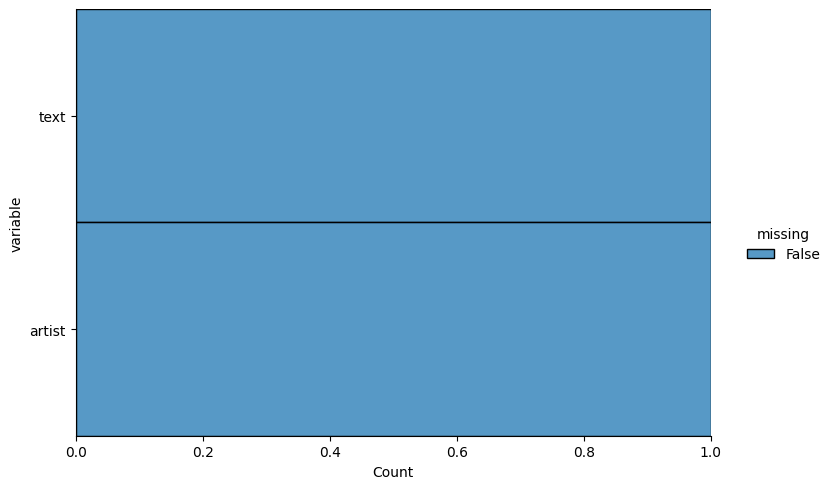

In [4]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.5
)

plt.show()

Zbiór nie zawiera duplikatów - zastosowanie klauzuli **DISTINCT** przy wykonaniu SQL-owskich kwerend pozwoliło nam na uniknięcie powtórzenia się wartości.
_____

The dataset does not contain any duplicates. By using the **DISTINCT** clause in our SQL queries, we were able to avoid the repetition of values and ensure that each value in the dataset is unique.

In [5]:
df[df.duplicated()]

,text,artist


W następnej komórce sprawdzimy, czy żaden z posiadanych tekstów nie zaczyna się od cyfry 1. Mogłoby to bowiem oznaczać, że w zbiór "zaplątała się" jakaś lista piosenek z albumu/singla. Na szczęście tak nie jest, ale output tej komórki uwidocznił nam inny kłopot, o istnieniu którego mogliśmy przypuszczać.
___

In the next cell, we will check if any of the texts in our dataset start with the digit 1. This could potentially indicate that a list of songs from an album/single got mixed into the dataset. Fortunately, that is not the case. However, the output of this cell revealed another issue that we could have anticipated.

In [6]:
df.loc[df['text'].str.startswith('1') == True]

,text,artist
1355,"1, 2, 3, 4 \nOur gum's are black our teeth are falling out \nWe got spots on our backs so give it up and shout \nWe got Scurvy we need some vitamin C \nWe got Scurvy we need a lemon tree \nWe got Scurvy we just chillin' on the sea \nLets get this Scurvy started \nA pirate ain't worthy \nTill he got some Scurvy \nSince you've got Scurvy on your nervy when you sing that song \nScurvy (Scurvy) \nWe got Scurvy (scurvy) \nWe got Scurvy (scurvy) \nWe got Scurvy (scurvy)\n\n",P!nk
2766,1st stanza \n \nAtin cu pung singsing \nMetung yang timpucan \nAmana que iti \nQng indung ibatan \nSancan queng sininup \nQng metung a caban \nMewala ya iti \nE cu camalayan! \n \n2nd stanza \nIng sucal ning lub cu \nSusucdul qng banua \nPicurus cung gamat \nBabo ning lamesa \nNinu mang manaquit \nQng singsing cung mana \nCalulung pusu cu \nManginu ya keta! \n \nRepeat 2nd stanza \n \nRepeat 1st stanza \n \nCalulung pusu cu \nManginu ya keta!\n\n,Freddie Aguilar
2912,14 cheerleader cold front \nPut your nose beyond \nCreeping boys in alleys \nFind them when your gone \n \nStick close to locker rooms \nAnd wavy clothes to wear \nYou will hold them dear \nTo something queer and stare \n \n16 used companions \nHave nowhere to stay \nGive them access to parking spaces \nNo coin meters there \n \nStick close to locker rooms \nAnd wavy clothes to wear \nYou will hold them dear \nTo something queer and stare \nYou will hold them dear \nTo something queer and stare\n\n,Guided By Voices
3064,"1st verse: \nLet the Earth rejoice \nSee the risen King \nOn the clouds of praise \nHe's exalted forever \n2nd verse: \nWe will rise with Him \nSon of righteousness \nAnd the Earth will shake \nIn the glory of heaven \nChorus: \nSee the heavens open wide \nAnd His glory like a flood \nFill the earth with salvation \nSee the nations take His hand \nAnd in righteousness, they stand \nThis is Jesus generation \n2nd verse \nChorus \nGlory, glory, glory, Emmanuel, God is with us (till the end)\n\n",Hillsong United


Chcielibyśmy pozbyć się z naszych tekstów wyrażeń regularnych oznaczających m.in. koniec wersu (**"\r"**), nowy wers (**"\n"**), zerowy odstęp szerokości (**"\u200b"**) itp. Zrobimy to za pomocą pętli, która iteruje po zadanej liście wyrażeń regularnych i aplikuje ją do każdego rekordu w ramce danych.
___

We would like to remove certain regular expressions from our texts, including line breaks (**"\r"**), new lines (**"\n"**), zero-width space (**"\u200b"**), and others. We will accomplish this using a loop that iterates over a given list of regular expressions and applies it to each record in the DataFrame.

In [7]:
expressions_to_remove = ["\n", "\r", '\r\n',
                         '\t', '\w', "\u200b"]  

for i in range(len(df['text'])):
    for expr in expressions_to_remove:
        df['text'][i] = df['text'][i].replace(expr, " ")
        
df.sample(5)

,text,artist
4115,I used to be an A student I never used to complain I used to be a truant But I'm still the same Bad bad brain Bad bad brain I used to go to parties I used to drink champagne Now I'm beginning to feel the strain Bad bad brain Bad bad brain I used to be in show biz I used to have fortune and fame I used to have pleasure and pain I used to have a name Bad bad brain Bad bad brain Now I'm on the Bowery I can't remember my name Bad bad brain Bad bad brain,Ramones
2968,How can you refuse him now how can you refuse him now How can you turn away from his side With tears in his eyes on the cross there he died How can you refuse Jesus now There's a story old that has often been told of how our Saviour died As they nailed his hands he cried they don't understand As the blood flowed from his side How can you refuse him now... [ steel ] As he hung there on the tree he prayed for you and me There was no one his pain to ease Before he died he faintly cried oh father forgive them please How can you refuse him now...,Hank Williams
1447,I've gone mental I've gone mental Out of the hospital Out against my will Life is so beautiful I've gone mental Mental mental I've killed my family They thought I was an oddity Life is so beautiful I am a vegetable Mental mental I've gone mental I've gone mental Staring at my goldfish bowl Popping phenobarbital Life is so beautiful I've gone mental Mental mental Sitting on my window sill Life is so beautiful I've become irrational I've gone mental Mental mental I've gone mental,Ramones
2399,"Never a word, a word so true Passed between us, me and you Heard you found your pot of gold That's the story I've been told Never a word was said in vain Some were never sad again Some were lost in lovers' heat Some lay fallen at our feet All day all night You and only you All day all night I think of you and only you Never a word escaped my lips Silenced by your fingertips I kept my word, can you believe All this time so hard to breathe Hard to breathe",Deep Purple
322,When the deep purple falls Over sleepy garden walls And the stars begin to flicker in the sky Through the mist of a memory You wander back to me Breathing my name with a sigh In the still of the night Once again I'll hold you tight Though you're gone your love lives on When moonlight beams And as long as my heart will beat Love we'll always meet Here in my deep purple dreams And as long as my heart will beat Love we'll always meet Here in my deep purple dreams,Dean Martin


Wspomnianym przeze mnie problemem w ramce danych jest występowanie tekstów w innym języku niż angielski. Przy użyciu funkcji **detect** z modułu **langdetect** stworzymy funkcję, która wykrywa język tekstu. Zaaplikujemy tę funkcję do całego zbioru danych i zapiszemy wyniki w odrębnej kolumnie **df["language"]**.
___

The mentioned issue in the DataFrame is the presence of texts in languages other than English. To address this, we can create a function using the **detect** function from the **langdetect** module to detect the language of a given text. We will apply this function to the entire dataset and store the results in a separate column, **df["language"]**.

In [8]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

df['language'] = df['text'].apply(detect_language)
df.sample(5)

,text,artist,language
2265,"I go to work in a bubble I got everything I need I get so high on no trouble It's a great feeling, being free I say a prayer at thanksgiving I bless the night and the day I look up to the sky with a smile on my face And I praise the lord of the new way The sweetest sound I ever knew Was the sound of reason falling Like the summer rain And the truth washed the pain away New way I don't watch tv anymore Don't need to see it now we all know the score And all the politicians know what they're there for It's a new way New way",Chris Rea,en
778,Come over here All you got is this moment The twenty-first century's yesterday You can care all you want Everybody does yeah that's okay So slide over here And give me a moment Your moves are so raw I've got to let you know I've got to let you know You're one of my kind I need you tonight 'cause I'm not sleeping There's something about you girl That makes me sweat How do you feel I'm lonely What do you think Can't take it all Whatcha gonna do Gonna live my life,INXS,en
2853,Like a long lonely stream I keep running for the dream Moving on moving on Like a branch on a tree I keep reaching to be free Moving on moving on There's a place in the sun Where there's hope for everyone Where my poor restless heart's gotta run There's a place in the sun And before my life is done Gotta find me a place in the sun Like a dusty old road I get weary from the load Moving on moving on Like this tired troubled earth I've been running since my birth Moving on moving on There's a place in the sun,Glen Campbell,en
1432,Super collider Dust in a moment Particles scatter Parting from the soup Swimming upstream Before the heavens crack open Thin pixelations Coming out from the dust In a blue light In a green light In a half light In a work light In a B-spin Flip flopping In a pulse wave Outstepping To put the shadows back into The boxes I am open I am welcome For a fraction Of a second I have jettisoned my illusions I have dislodged my depressions I put the shadows back into The boxes,Radiohead,en
3303,"Didn't I make all your dreams come true Didn't they work the way you wanted it too Didn't I do what I promised to you I understand it's just love, love So don't give upon love, love, love Don't give upon love. Losing you is so hard for me 'Cause loving you came so easily But we see things so differently I understand it's just love. I'll do what I can to carry on 'Cause I've loved you before I can not love you more It's just love, love, love...",Kenny Rogers,en


Następny krok jest bardzo prosty - usuwamy ze zbioru teksty o innej wartości języka niż **"en"**. Tym samym pozbyliśmy się ze zbioru 88 piosenek. **UWAGA:** metoda detect, na której oparta jest zastosowana przez nas funkcja, jest metodą korzystającą z pewnej losowości przy detekcji - w wypadku ponownego uruchomienia kodu może skutkować innymi przypisaniami języka do tekstu.
___

The next step is very simple - we remove texts from the dataset that have a language value other than **"en"** (English). By doing this, we have eliminated 88 songs from the dataset. **NOTE:** The detect method, on which our applied function is based, relies on some randomness in language detection. Therefore, if you run the code again, it may result in different language assignments for the texts.

In [9]:
df = df[df['language'] == 'en']
df

,text,artist,language
0,"Well, you hoot and you holler and you make me mad And I've always been under your heel Holy christ what a lousy deal Now I'm sick and tired of your tedious ways And I ain't gonna take it no more Oh no no - walkin' out that door Burning my bridges, cutting my tie Once again I wanna look into the eye Being myself Counting my pride No un-right neighbour's gonna take me for a ride Burning my bridges Moving at last Girl I'm leaving and I'm burying the past Gonna have peace now You can be free No one here will make a sucker out of me",ABBA,en
1,"I'm down and I feel depressed Sitting here just waiting For next bus travelling Downtown It's a crying shame Isn't it The beautiful weather If I could have my way Well, I would not be working On a day like this I know what I'd like to be As free as a bumble bee Take a sip from Every flower Free as a bumble bee While away each lazy hour What a good life Lying laid back Like an old railroad bum by the track What a good life Living outdoors Lie in the grass and chew on a straw",ABBA,en
2,Just a notion that's all Just a feeling that you're watchin' me Every move I'm making Am I reading your mind Cause it's almost like you're touching me There is no mistaking Just a notion That you'll be walkin' up to me In a while And you smile and say hello Then we'll be dancing through the night Knowing everything from there on Must be right Just a notion But somehow I know I'm not wrong If it's our destiny there's nothing we can do But tonight is very special It's the night for me and you,ABBA,en
3,"The poster on the wall of a dear friend I wish there was a way that I could show you how your songs set me free The hero of them all You're a legend I guess I'll never get a chance to know you Still you're close as can be Make the bandstand to a dreamland, Rubber Ball Man Clapping your hands, let your feet dance, Rubber Ball Man When you're jumping up and down, nobody's standing still Some of us dreaming, some of us screaming Look at your fans, how we love you, Rubber Ball Man!",ABBA,en
4,"Suzy was nine and I was ten Right at the time when boys like to think they're men She used to follow us at school We really thought that she was a little fool And one day we said to her We don't want to hurt you girl But you'd better Look for a friend of your own, Suzy-hang-around Better come back when you're grown, Suzy-hang-around Nobody wants you around here and that's for sure So get off our playground and stay away That's all that we've got to say Suzy-hang-around Suzy went home to Mama's arms Mama said",ABBA,en
...,...,...,...
4713,I see you across the room Search for some happiness ain't anytime soon Turmoil has turned you inside Sift through your pages of miracles you wish to find [Chorus] When you're too numb to cry And you're just left wondering why When you're too numb to cry And you're just left wondering why To change in the blink of an eye If you could you surely would wave yourself goodbye I try and I try and I try Get a hold on your suffering Peace in which you don't wish to buy,Zakk Wylde,en
4714,"2, 3, 4, 1, drank all my fuckin' brew And I ain't got's no more Feeling so damn tired Running on desperate fumes For the end is always near, now Empty handed it's always soon Psychocise me, terrify me Jeopardizing all that's mine Megolamize me, certify me On my knees until I cry Lord only knows where I've gone Lord only knows where I've been In a world of trouble again worries Streaming 'round the bend Treat me like a dog, now Knowing I won't turn Blind me like a slave, now Cast down no concern",Zakk Wylde,en
4715,"Dear Tiffany, You've mad me nauseous for the last time Everything I've said to you, I will form a spike (to drive through my throat) In order to stop my words This time I'll put them in the ground along with my memories and my feelings I'll burn it down and walk away Let the fire warm my back I wish you would say you hate me It would make it so much easier Burn it down and walk away,

Kolumna "language" spełniła swoją rolę i możemy ją z powodzeniem usunąć ze zbioru.
___
The "language" column has served its purpose, and we can safely remove it from the dataset. 

In [10]:
df = df.drop('language', axis=1)
df

,text,artist
0,"Well, you hoot and you holler and you make me mad And I've always been under your heel Holy christ what a lousy deal Now I'm sick and tired of your tedious ways And I ain't gonna take it no more Oh no no - walkin' out that door Burning my bridges, cutting my tie Once again I wanna look into the eye Being myself Counting my pride No un-right neighbour's gonna take me for a ride Burning my bridges Moving at last Girl I'm leaving and I'm burying the past Gonna have peace now You can be free No one here will make a sucker out of me",ABBA
1,"I'm down and I feel depressed Sitting here just waiting For next bus travelling Downtown It's a crying shame Isn't it The beautiful weather If I could have my way Well, I would not be working On a day like this I know what I'd like to be As free as a bumble bee Take a sip from Every flower Free as a bumble bee While away each lazy hour What a good life Lying laid back Like an old railroad bum by the track What a good life Living outdoors Lie in the grass and chew on a straw",ABBA
2,Just a notion that's all Just a feeling that you're watchin' me Every move I'm making Am I reading your mind Cause it's almost like you're touching me There is no mistaking Just a notion That you'll be walkin' up to me In a while And you smile and say hello Then we'll be dancing through the night Knowing everything from there on Must be right Just a notion But somehow I know I'm not wrong If it's our destiny there's nothing we can do But tonight is very special It's the night for me and you,ABBA
3,"The poster on the wall of a dear friend I wish there was a way that I could show you how your songs set me free The hero of them all You're a legend I guess I'll never get a chance to know you Still you're close as can be Make the bandstand to a dreamland, Rubber Ball Man Clapping your hands, let your feet dance, Rubber Ball Man When you're jumping up and down, nobody's standing still Some of us dreaming, some of us screaming Look at your fans, how we love you, Rubber Ball Man!",ABBA
4,"Suzy was nine and I was ten Right at the time when boys like to think they're men She used to follow us at school We really thought that she was a little fool And one day we said to her We don't want to hurt you girl But you'd better Look for a friend of your own, Suzy-hang-around Better come back when you're grown, Suzy-hang-around Nobody wants you around here and that's for sure So get off our playground and stay away That's all that we've got to say Suzy-hang-around Suzy went home to Mama's arms Mama said",ABBA
...,...,...
4713,I see you across the room Search for some happiness ain't anytime soon Turmoil has turned you inside Sift through your pages of miracles you wish to find [Chorus] When you're too numb to cry And you're just left wondering why When you're too numb to cry And you're just left wondering why To change in the blink of an eye If you could you surely would wave yourself goodbye I try and I try and I try Get a hold on your suffering Peace in which you don't wish to buy,Zakk Wylde
4714,"2, 3, 4, 1, drank all my fuckin' brew And I ain't got's no more Feeling so damn tired Running on desperate fumes For the end is always near, now Empty handed it's always soon Psychocise me, terrify me Jeopardizing all that's mine Megolamize me, certify me On my knees until I cry Lord only knows where I've gone Lord only knows where I've been In a world of trouble again worries Streaming 'round the bend Treat me like a dog, now Knowing I won't turn Blind me like a slave, now Cast down no concern",Zakk Wylde
4715,"Dear Tiffany, You've mad me nauseous for the last time Everything I've said to you, I will form a spike (to drive through my throat) In order to stop my words This time I'll put them in the ground along with my memories and my feelings I'll burn it down and walk away Let the fire warm my back I wish you would say you hate me It would make it so much easier Burn it down and walk away, Love Daniel",Zao
4716,"Your eyes 

Nie zaszkodzi sprawdzić rozkładu długości tekstów piosenek przy użyciu histogramu z nałożoną nań krzywą **KDE** (kernel density estimate). Rozkład jest wyraźnie **negatywnie (lewostronnie) skośny** - jest asymetryczny, większa część wartości znajduje się po prawej stronie średniej, podczas gdy ogon rozkładu rozciąga się w lewo, zaś mediana jest wyższa od średniej. Tak jest w tym wypadku - w rozkładzie wartości 400 - 600 (mimo pierwotnego odfiltrowania wartości od 300 minimalna wartość okazuje się wynosić 400) najwięcej rekordów koncentruje się między 525 a 575 znakami. Rozkład jest przy tym względnie wysoko rozproszony wokół średniej - na podstawie samej obserwacji możemy założyć, iż ma **niską kurtozę**. 

Dla sprawdzenia powyższego rozkładu stworzyliśmy kolumnę **"text_length"**, która zostanie usunięta po wykorzystaniu.
___

It wouldn't hurt to examine the distribution of song text lengths using a histogram with an overlaid **KDE** (kernel density estimate) curve. The distribution is clearly **negatively (left) skewed** - it is asymmetrical, with the majority of values located to the right of the mean, while the tail of the distribution extends to the left, and the median is higher than the mean. In this case, within the range of values from 400 to 600 (despite the initial filtering of values below 300, the minimum value turns out to be 400), the majority of records are concentrated between 525 and 575 characters. The distribution is also relatively widely spread around the mean - based on this observation alone, we can assume it has **low kurtosis**.

To examine the aforementioned distribution, we created a column called **"text_length"**, which will be removed after its use.

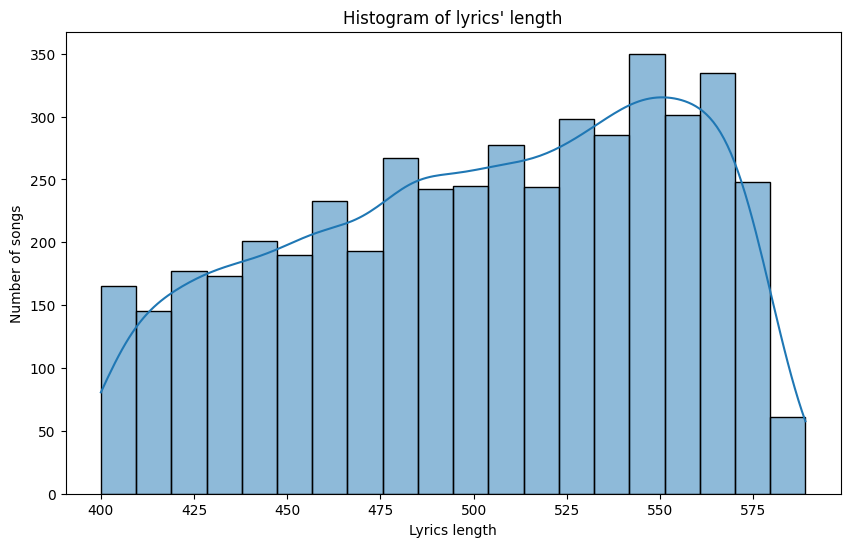

In [11]:
plt.figure(figsize=(10, 6))
df['text_length'] = df['text'].apply(len)
sns.histplot(df['text_length'], kde=True, bins=20)
plt.xlabel('Lyrics length')
plt.ylabel('Number of songs')
plt.title("Histogram of lyrics' length")
plt.show()

Sprawdźmy nadto, jak przedstawia się "wkład ilościowy" poszczególnych artystów w nasz zbiór, co zobrazujemy wykresem typu **countplot**. Niestety, z uwagi na znaczną liczność tychże artystów (531) wykres jest nieczytelny - słupki są nieuszeregowane, jest ich mnóstwo, a spis artystów zlewa się w czarną masę, z której nie sposób cokolwiek odczytać.
___

Let's examine the "quantitative contribution" of each artist to our dataset using a **countplot**. Unfortunately, due to the significant number of artists (531), the plot becomes unreadable. The bars are unordered, there are too many of them, and the list of artists blends into a black mass, making it impossible to read anything.

In [12]:
df['artist'].value_counts()

Billie Holiday          61
Hillsong United         55
Radiohead               47
Dean Martin             47
Frank Sinatra           46
                        ..
Bryan White             1 
Bosson                  1 
Bob Marley              1 
Beauty And The Beast    1 
X Japan                 1 
Name: artist, Length: 531, dtype: int64

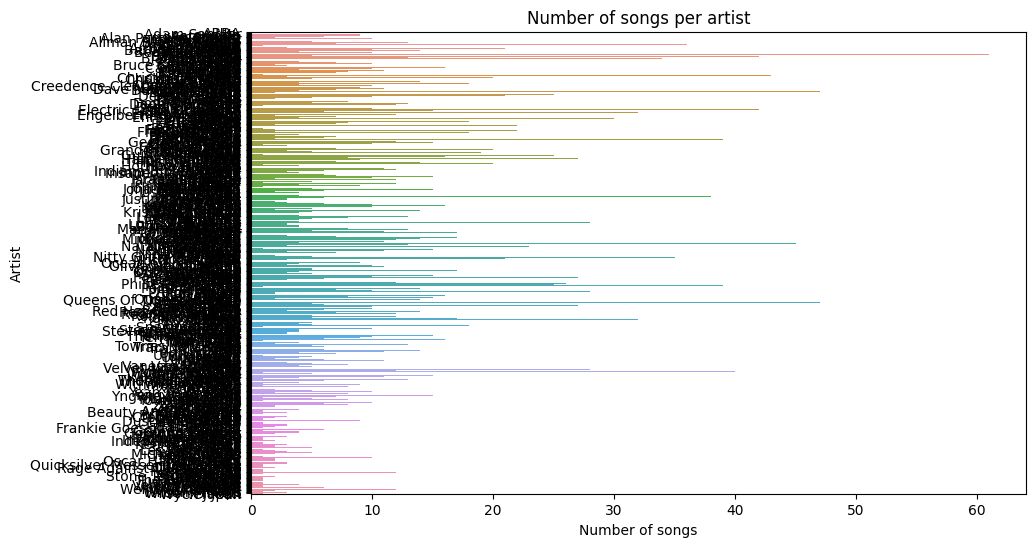

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='artist')
plt.xlabel('Number of songs')
plt.ylabel('Artist')
plt.title('Number of songs per artist')
plt.show()

Countplot należy poprawić - uwzględniamy w nim zatem tylko artystów, których piosenki występują w zbiorze ponad 30 razy, i szeregujemy słupki wg liczebności wystąpień.

Co ciekawe, bardzo licznie reprezentowani w zbiorze są wykonawcy tradycyjnego amerykańskiego popu, jak **Billie Holiday**, **Dean Martin**, **Frank Sinatra**, **Nat King Cole** czy **Bing Crosby**. W pierwszej trójce na liście znalazły się: słynący z mocno refleksyjnych i niepokojących tekstów zespół **Radiohead**, jak również chrześcijańska grupa **Hillsong United**. Można zatem a priori zakładać sporą różnorodność emocjonalną tekstów.
___
We will improve the countplot by considering only artists whose songs appear in the dataset more than 30 times, and we will sort the bars according to the frequency of occurrences.

Interestingly, the dataset is heavily represented by artists from traditional American pop, such as **Billie Holiday**, **Dean Martin**, **Frank Sinatra**, **Nat King Cole**, and **Bing Crosby**. In the top three of the list, we find the renowned band **Radiohead**, known for their deeply reflective and haunting lyrics, as well as the Christian group **Hillsong United**. This suggests a significant emotional diversity in the song lyrics.

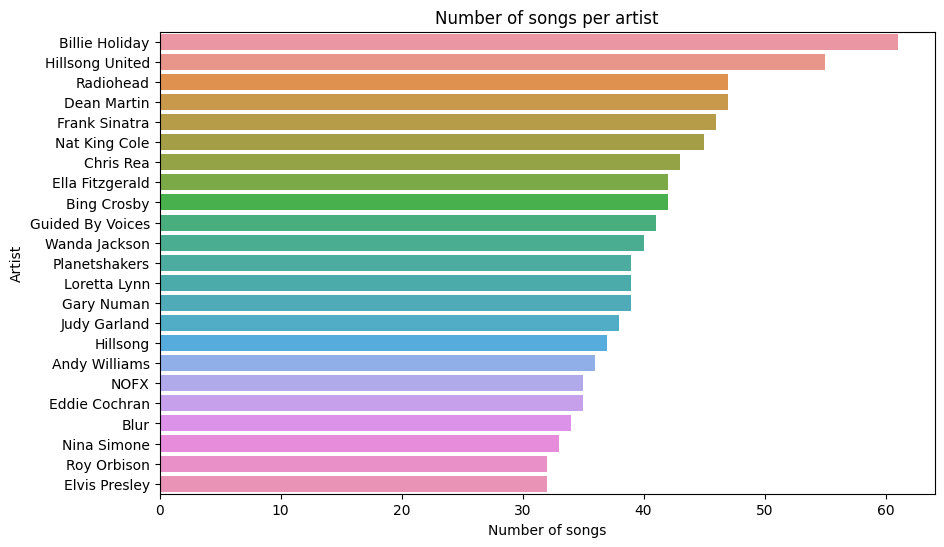

In [14]:
plt.figure(figsize=(10, 6))
artist_counts = df['artist'].value_counts()
selected_artists = artist_counts[artist_counts > 30].index
selected_artists_counts = artist_counts[selected_artists].sort_values(ascending=False)

sns.countplot(data=df[df['artist'].isin(selected_artists)], y='artist', order=selected_artists_counts.index)
plt.xlabel('Number of songs')
plt.ylabel('Artist')
plt.title('Number of songs per artist')
plt.show()

Zgodnie z zapowiedzią usuwam kolumnę "text_length".
___

As announced, I will remove the "text_length" column.

In [15]:
df = df.drop('text_length', axis=1)
df

,text,artist
0,"Well, you hoot and you holler and you make me mad And I've always been under your heel Holy christ what a lousy deal Now I'm sick and tired of your tedious ways And I ain't gonna take it no more Oh no no - walkin' out that door Burning my bridges, cutting my tie Once again I wanna look into the eye Being myself Counting my pride No un-right neighbour's gonna take me for a ride Burning my bridges Moving at last Girl I'm leaving and I'm burying the past Gonna have peace now You can be free No one here will make a sucker out of me",ABBA
1,"I'm down and I feel depressed Sitting here just waiting For next bus travelling Downtown It's a crying shame Isn't it The beautiful weather If I could have my way Well, I would not be working On a day like this I know what I'd like to be As free as a bumble bee Take a sip from Every flower Free as a bumble bee While away each lazy hour What a good life Lying laid back Like an old railroad bum by the track What a good life Living outdoors Lie in the grass and chew on a straw",ABBA
2,Just a notion that's all Just a feeling that you're watchin' me Every move I'm making Am I reading your mind Cause it's almost like you're touching me There is no mistaking Just a notion That you'll be walkin' up to me In a while And you smile and say hello Then we'll be dancing through the night Knowing everything from there on Must be right Just a notion But somehow I know I'm not wrong If it's our destiny there's nothing we can do But tonight is very special It's the night for me and you,ABBA
3,"The poster on the wall of a dear friend I wish there was a way that I could show you how your songs set me free The hero of them all You're a legend I guess I'll never get a chance to know you Still you're close as can be Make the bandstand to a dreamland, Rubber Ball Man Clapping your hands, let your feet dance, Rubber Ball Man When you're jumping up and down, nobody's standing still Some of us dreaming, some of us screaming Look at your fans, how we love you, Rubber Ball Man!",ABBA
4,"Suzy was nine and I was ten Right at the time when boys like to think they're men She used to follow us at school We really thought that she was a little fool And one day we said to her We don't want to hurt you girl But you'd better Look for a friend of your own, Suzy-hang-around Better come back when you're grown, Suzy-hang-around Nobody wants you around here and that's for sure So get off our playground and stay away That's all that we've got to say Suzy-hang-around Suzy went home to Mama's arms Mama said",ABBA
...,...,...
4713,I see you across the room Search for some happiness ain't anytime soon Turmoil has turned you inside Sift through your pages of miracles you wish to find [Chorus] When you're too numb to cry And you're just left wondering why When you're too numb to cry And you're just left wondering why To change in the blink of an eye If you could you surely would wave yourself goodbye I try and I try and I try Get a hold on your suffering Peace in which you don't wish to buy,Zakk Wylde
4714,"2, 3, 4, 1, drank all my fuckin' brew And I ain't got's no more Feeling so damn tired Running on desperate fumes For the end is always near, now Empty handed it's always soon Psychocise me, terrify me Jeopardizing all that's mine Megolamize me, certify me On my knees until I cry Lord only knows where I've gone Lord only knows where I've been In a world of trouble again worries Streaming 'round the bend Treat me like a dog, now Knowing I won't turn Blind me like a slave, now Cast down no concern",Zakk Wylde
4715,"Dear Tiffany, You've mad me nauseous for the last time Everything I've said to you, I will form a spike (to drive through my throat) In order to stop my words This time I'll put them in the ground along with my memories and my feelings I'll burn it down and walk away Let the fire warm my back I wish you would say you hate me It would make it so much easier Burn it down and walk away, Love Daniel",Zao
4716,"Your eyes 

# Implementacja modeli przetwarzania języka opartych na BERT/Implementation of BERT-based language processing models.

Boards of Canada to szkocki (wbrew nazwie) duet nagrywający muzykę elektroniczną. Tak się składa, że w przetwarzanym datasecie nie ma on swojego przedstawiciela (czyżby dlatego, że nagrywał wyłącznie instrumentale?), ale nie znaczy to, że z tym projektem nie ma nic wspólnego. Nagrał on bowiem kiedyś utwór "Music is Math", którego tytuł mógłby spokojnie posłużyć za motto tegoż notatnika.

W tej sekwencji zastosujemy dwa oparte na **BERT** modele przetwarzania języka, którym powierzymy dwa odrębne zadania z tego zakresu. Czym takim jest właśnie ten główny model? BERT, a właściwie **Bidirectional Encoder Representations from Transformers**, to model wytrenowany na ogromnych zbiorach danych tekstowych: zbiorów uniwersyteckich, artykułów prasowych, postów w mediach społecznościowych etc. Tym, co go wyróżnia, to znakomita skuteczność, zbliżona do percepcji języka naturalnego przez człowieka; BERT dokonuje predykcji słów w kontekście zdania, dzięki czemu potrafi rozpoznawać kontekst i znaczenie słów zawartych w sekwencji tekstowej. Sama architektura tego modelu wykorzystuje warstwy typu **Transformer**, na które z kolei składają się mechanizm uwagi (dzięki któremu model "skupia się" na odpowiednich fragmentach sekwencji wejściowej i rozpoznaje zależności między nimi) i warstw sieci neuronowych typu Multi-Layer-Perceptrons.

Tyle teorii, pora na praktykę. Pierwszym modelem, który wykorzystamy, jest **EkmanClassifier**. Nie jest to model o szczególnej popularności (w momencie, w którym piszę te słowa, liczba pobrań z witryny huggingface.co wynosi raptem 304), ale będzie on dla nas bardzo wartościowy. Cóż takiego czyni ten model? Mianowicie dąży do rozpoznania w przekazanej sekwencji tekstu sentymentu na podstawie **klasyfikacji Ekmana**. Paul Ekman, obecnie emerytowany profesor University of California San Francisco, wyróżnił sześć podstawowych emocji człowieka: złość (anger), wstręt (disgust), strach (fear), radość (joy), smutek (sadness) i zdziwienie (surprise). W naszym modelu do ww. uczuć dodana została etykieta "neutral", co odpowiadać może neutralności uczuciowej. 

Ponieważ chcemy, aby każdemu z uczuć została przypisana wartość prawdopobieństwa jego wystąpienia, pipeline'owi czynności wykonanych w ramach zadania (tokenizacja, zastosowany rodzaj predefiniowanego i wstępnie wyuczonego modelu) wskażemy argument **return_all_scores=True**.

___________________

Boards of Canada is a Scottish (despite the name) electronic music duo. Interestingly, they don't have a representative in the dataset we are working with (maybe because they only produce instrumental tracks), but that doesn't mean they have nothing to do with this project. They have actually recorded a song called "Music is Math," which could easily serve as the motto for this notebook.

In this sequence, we will use two language processing models based on BERT, each assigned to perform a separate task. So, what is this main model all about? BERT, which stands for **Bidirectional Encoder Representations from Transformers**, is a model trained on massive amounts of textual data, including university collections, news articles, social media posts, and more. What sets it apart is its exceptional effectiveness, approaching the level of human natural language understanding. BERT predicts words based on the context of a sentence, enabling it to recognize the context and meaning of words within a text sequence. The architecture of this model utilizes Transformer layers, which consist of attention mechanisms (allowing the model to focus on relevant parts of the input sequence and recognize dependencies between them) and Multi-Layer Perceptron neural network layers.

Enough theory, let's move on to practice. The first model we will use is the **EkmanClassifier**. It may not be widely known (at the time of writing this, it has only been downloaded 304 times from the huggingface.co website), but it will be highly valuable for our purposes. What does this model do? It aims to recognize the sentiment in a given text sequence based on **Ekman's classification**. Paul Ekman, a retired professor from the University of California, San Francisco, identified six basic human emotions: anger, disgust, fear, joy, sadness, and surprise. In our model, we add the "neutral" label, which corresponds to emotional neutrality.

To assign a probability value to each emotion, indicating the likelihood of its occurrence, we will set the argument **return_all_scores=True** in the pipeline of tasks performed (including tokenization and the use of a predefined and pre-trained model).

In [16]:
multi_model_name = "arpanghoshal/EkmanClassifier"
multi_tokenizer = AutoTokenizer.from_pretrained(multi_model_name)
multi_model = AutoModelForSequenceClassification.from_pretrained(multi_model_name)
pipeline_emotion = pipeline('sentiment-analysis', model=multi_model, tokenizer=multi_tokenizer, return_all_scores=True)

Dzięki zastosowaniu pipeline'u czynności i wstępnie zdefiniowanego modelu typu **AutoModelForSequenceClassification** (ze wstępnie zainicjowanymi parametrami i wagami) implementacja modelu jest banalnie łatwa. Samo przetestowanie modelu na pojedynczym rekordzie przyniosło skutek zgodny z oczekiwaniami - zwrócone zostały prawdopodobieństwa wystąpienia danego sentymentu jako przeważającego w formie wartości ciągłej z zakresu 0-1.
___
By using the pipeline of tasks and a pre-defined model of type **AutoModelForSequenceClassification** with pre-initialized parameters and weights, implementing the model becomes extremely easy. Testing the model on a single record yielded the expected result, with the probabilities of each sentiment being returned as dominant values in the range of 0 to 1.


In [17]:
pipeline_emotion(df['text'][0])

[[{'label': 'anger', 'score': 0.6761679649353027},
  {'label': 'disgust', 'score': 0.012154963798820972},
  {'label': 'fear', 'score': 0.003575355978682637},
  {'label': 'joy', 'score': 0.017877720296382904},
  {'label': 'neutral', 'score': 0.1482202410697937},
  {'label': 'sadness', 'score': 0.1279287338256836},
  {'label': 'surprise', 'score': 0.014075001701712608}]]

Zaimplementujmy model do całości zbioru. W tym celu wykonamy dwie pętle. Pierwsza zbuduje kolumny (wstępnie wypełnione zerami) odpowiadające uczuciom zwracanym przez model, druga z nich (działająca dłużej, dlatego skontrolujemy jej działanie za pomocą funkcji tqdm) będzie przypisywać zwrócone przez model wartości poszczególnym rekordom w zbiorze.
___
To implement the model on the entire dataset, we'll use two loops. The first loop will create columns (initially filled with zeros) corresponding to the sentiments returned by the model. The second loop, which may take longer to execute, will assign the values returned by the model to each record in the dataset. To track the progress of the second loop, we'll use the tqdm function.

In [18]:
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

for emotion in emotions:
    df[emotion] = 0.0

for index, row in tqdm(df.iterrows()):
    result = pipeline_emotion(row['text'])
    for i, emotion in enumerate(emotions):
        df.at[index, emotion] = result[0][i]['score']

4630it [32:56,  2.34it/s]


Łącznie pętla przeprowadzała iteracje w dość długim czasie (i to pomimo faktu, że model działał na dość krótkich sekwencjach). Na szczęście rezultaty jej działania są szalenie interesujące.
___
The loop iterated for quite a long time overall (despite the fact that the model was processing relatively short sequences). Fortunately, the results of its operation are extremely interesting.

In [19]:
df.sample(5)

,text,artist,anger,disgust,fear,joy,neutral,sadness,surprise
4093,"sit down, stand up sit down, stand up walk into the jaws of hell (sit down, stand up) walk into the jaws of hell (sit down, stand up) anytime (sit down) anytime (stand up) sit down, stand up sit down, stand up we can wipe you out anytime (sit down, stand up) we can wipe you out (sit down, stand up) anytime (sit down) anytime stand up (the rain drops the rain drops) sit down (the rain drops the rain drops) oh the rain drops x46",Radiohead,0.065881,0.002566,0.000454,0.019936,0.907218,0.002078,0.001867
3877,"I'd rather be a sparrow than a snail Yes I would If I could, I surely would I'd rather be a hammer than a nail. Yes I would If I only could, I surely would. Away, I'd rather sail away Like a swan that's here and gone A man gets tied up to the ground He gives the world Its saddest sound, its saddest sound I'd rather be a forest than a street. Yes I would If I could, I surely would. I'd rather feel the earth beneath my feet Yes I would If I only could, I surely would",Paul Simon,0.005927,0.000382,0.001219,0.048913,0.038371,0.900390,0.004798
2963,Written by Bonnie Dodd - Charles Mitchell Recorded by Hank Snow If it's wrong to love you wrong I'll alway be Though the world may scorn me darling can't you see If it's wrong to want you when my day is through Gladly I will pay for all my dreams of you (Though we met too late dear and you'll never know That without a right to I have loved you so) I can't change my heart dear you're a part of me If it's wrong to love you wrong I'll always be Though we met too late dear...,Hank Snow,0.005455,0.000101,0.000152,0.971113,0.013592,0.006758,0.002829
3305,"Take my hand, pull me up Find my own way soon enough You'll see me through, see me through What you give will see me through When my mind cannot reach You can show me harmony That sees me through, sees me through What you teach will see me through You told me, you showed me And when you're working day was done I watched you go, I should have known That even when I feel alone You'll see me through, see me through When I need you, you'll see me through",Kenny Rogers,0.010945,0.000485,0.007542,0.107895,0.781860,0.029384,0.061890
1223,"Get off your high horse lady, I don't need a ride tonight Get off your high horse lady, I don't need a ride tonight Lay down I hear your soul song singing from a fire in the sky I hear your soul song singing from a fire in the sky Rain down Rain down Get off your high horse lady, I don't need a ride tonight Get off your high horse lady, I don't need a ride tonight Lay down Lay down",Oasis,0.827878,0.005084,0.000809,0.012585,0.140504,0.009619,0.003520


Kolejny model będzie korzystał z uproszczonej wersji algorytmu BERT. Ideą przyświecającą stworzeniu modelu **DistilBERT** było zmniejszenie rozmiaru modelu BERT i jego przyspieszenie obliczeniowe, zachowując jednocześnie jego zdolności do reprezentacji języka. Model ten posiada bardziej skompresowaną liczbę warstw i uczy się przy wykorzystaniu wiedzy posiadanej przez BERT, który w tym układzie pełni rolę nauczyciela. Zastosowany model **distilbert-base-uncased-finetuned-sst-2-english** (jeden z najpopularniejszych modeli opartych na warstwach Transformer) pozwoli nam na realizację zadania klasyfikacji tekstu wg dwóch klas sentymentu - pozytywnego i negatywnego. Prócz przypisania do dominującej klasy chcemy, aby również i ten model zwracał nam wartości prawdopodobieństwa przynależności do danej klasy sentymentu.
___
The next model will utilize a simplified version of the BERT algorithm. The idea behind creating the **DistilBERT** model was to reduce the size of the BERT model and improve computational efficiency while preserving its language representation capabilities. This model has a smaller number of layers and learns from the knowledge of BERT, which acts as the teacher in this setup. The chosen model, **distilbert-base-uncased-finetuned-sst-2-english**, is one of the most popular models based on Transformer layers. It will allow us to perform sentiment classification task with two classes: positive and negative. In addition to assigning the dominant class, we also want this model to provide probability values of belonging to each sentiment class.

In [20]:
bin_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
bin_tokenizer = AutoTokenizer.from_pretrained(bin_model_name)
bin_model = AutoModelForSequenceClassification.from_pretrained(bin_model_name)
pipeline_classifier = pipeline('text-classification', model=bin_model, tokenizer=bin_tokenizer, return_all_scores=True)

W przypadku przewidywania binarnego sentymentu zadziałamy podobnie do poprzedniego zadania, z tą różnicą, że sentyment dominujący przypisany zostanie do kolumny z wartościami tekstowymi. Wyświetlenie próbki wyników pokazuje, że zadanie zakończyło się sukcesem (aczkolwiek i tutaj pochłonęło nam dość dużo czasu).
___
For binary sentiment prediction, we will follow a similar approach to the previous task, with the difference that the dominant sentiment will be assigned to the column containing the text values. Displaying a sample of the results shows that the task has been successful (although it also took a considerable amount of time).

In [21]:
df['negative'] = 0.0
df['positive'] = 0.0

for index, row in tqdm(df.iterrows()):
    result = pipeline_classifier(row['text'])
    
    negative_prob = result[0][0]['score']
    
    positive_prob = 1.0 - negative_prob
    
    df.at[index, 'positive'] = positive_prob
    df.at[index, 'negative'] = negative_prob
    
    if positive_prob > negative_prob:
        df.at[index, 'labels_bin'] = 'positive'
    else:
        df.at[index, 'labels_bin'] = 'negative'

4630it [18:55,  4.08it/s]


In [22]:
df.sample(5)

,text,artist,anger,disgust,fear,joy,neutral,sadness,surprise,negative,positive,labels_bin
1243,"She woke from a dream Her head was on fire Why was he so nervous? He took her to the park She crossed her arms And lowered her eyelids [Chorus] Someday somebody's gonna ask you A question that You should say ""yes"" to Once in your life Maybe tonight I've got a question for you She'd had no idea Started to cry, She said in a good way He took her by the hand Walked her back home They took the long way [Chorus]",Old 97's,0.019348,0.001023,0.035627,0.044124,0.379196,0.059715,0.460968,0.002487,0.997513,positive
4002,Your life is leaning downhill Sloping off the outer edge Your undetermined oyster beds Were found to be a hedge You caused the kids of Elmer Fudd To feed the farmer whose Cadaver's filled with onion rings And feet are filled with glue Now sinister exaggerator What's your claim to fame? Is still your favorite Ferlinghetti Found in Auntie Maim? Your alter life is superseded Only from above Your heart is like a silken sponge That calls saliva love,Primus,0.020035,0.000874,0.000674,0.009041,0.407483,0.007625,0.554268,0.971105,0.028895,negative
2692,"Over the hills they came from the valley Making innuendos about my lack of talent, oh well They say that when I'm supposed to be singing All I 'm really doing is yelling, oh well To you I say Break out or get out Then they say that I can't sing That I don't say a thing That I make everything up oh well To you I say Break out or get out Break out or get out Get out of your mind Cause it's much too small And there's so much going on",Faith No More,0.131187,0.002395,0.001505,0.009756,0.747461,0.055290,0.052405,0.999146,0.000854,negative
1898,"The walls of my mind are closin' in. Can't get away. Your mem'ry won't end. [Chorus:] Can't forget about you. Can't forget about you. Can't forget about you. Can't forget about you. Breakin' my mind in three quarter time makin' me blue. Can't forget about you. Can't forget about you. I never stop hearin' the music after the song is through. I still see your eyes, your warm, gentle smile. It was all worthwhile, each moment we knew. [Chorus]",Alabama,0.004836,0.000106,0.000186,0.950061,0.015518,0.021242,0.008051,0.000222,0.999778,positive
40,"O Master, let me walk with Thee In lowly paths of service free Tell me Thy secret, help me hear The strain of toil, the fret of care Teach me Thy patience, still with Thee In closer, dearer company In work that keeps faith sweet and strong In truth that triumphs over wrong O Master let me walk with Thee In closer, dearer company O Master let me walk with Thee Let me walk with Thee In hope that sends a shining ray Far down the future's broadening way In peace that only Thou canst give With Thee, O Master, let me live",Amy Grant,0.004606,0.000195,0.000548,0.421461,0.533946,0.007837,0.031406,0.000729,0.999271,positive


Reasumując - segment ten posłużył nie tylko przypisaniu etykiet i wartości ciągłych do poszczególnych rekordów. Jego zadaniem była również demonstracja, jak potężnym, a przy prostym w obsłudze narzędziem są modele językowe BERT. Jeżeli nie zależy nam na dostrajaniu parametrów czy budowaniu własnych, skomplikowanych architektur, możemy poprzestać na załadowaniu modelu językowego i zdefiniowania pipeline'a z zadaniem do wykonania (zdefiniowanie tokenizera i architektury, choć wykonane przeze mnie, nie jest obligatoryjne), a następnie zastosowania go do wskazanego zadania. Algorytm dysponuje etykietami, które przypisuje do próbek, ale same dane nie muszą zawierać etykiet - dzieje się tak, gdyż model nie musi się uczyć na danych ze zbioru, albowiem wcześniej już został w tym celu wyuczony.

Tę sekcję zakończymy sprawdzeniem statystyk opisowych dla zbioru po nadaniu mu wartości prawdopodobieństw występowania sentymentu. "Everything in its right place" - można by tak nawiązać do jednego z najliczniej reprezentowanych wykonawców. Średnie poszczególnych wartości sumują się do 1 (zarówno jeśli chodzi o podział ekmanowski, jak i negatywny-pozytywny), wartości zostały przypisane wszystkim próbkom ze zbioru. Sama ta tabelka może być jednak znacznie bardziej atrakcyjnie przedstawiona, co z pewnością wpłynie na jej informatywność.
___
To summarize, this segment served not only to assign labels and continuous values to individual records but also to demonstrate how powerful and user-friendly BERT language models can be. If we don't need to fine-tune parameters or build our own complex architectures, we can simply load a pre-trained language model, define a pipeline with the task at hand (although the tokenizer and architecture I used were defined, they are not obligatory), and apply it to the desired task. The algorithm provides labels that are assigned to samples, but the data itself doesn't have to contain labels because the model doesn't need to learn from the dataset since it has already been trained for that purpose.

We'll conclude this section by checking the descriptive statistics for the dataset after assigning sentiment probabilities to it. "Everything in its right place" - one could say, referencing one of the most represented artists. The means of the individual values sum up to 1 (both for the Ekman and positive-negative division), and the values have been assigned to all samples in the dataset. However, the presentation of this table can be made much more visually appealing, which will certainly enhance its informativeness.

In [23]:
df.describe()

,anger,disgust,fear,joy,neutral,sadness,surprise,negative,positive
count,4630.000000,4630.000000,4630.000000,4630.000000,4630.000000,4630.000000,4630.000000,4630.000000,4630.000000
mean,0.055167,0.001961,0.020157,0.417575,0.274920,0.095427,0.134793,0.415690,0.584310
std,0.121640,0.018623,0.108943,0.390423,0.308082,0.190196,0.230093,0.457552,0.457552
min,0.000036,0.000010,0.000009,0.001709,0.000081,0.000043,0.000040,0.000116,0.000214
25%,0.003765,0.000191,0.000351,0.037206,0.022912,0.004837,0.005325,0.002056,0.017930
50%,0.011560,0.000443,0.001038,0.266757,0.129225,0.017038,0.021982,0.056085,0.943915
75%,0.040627,0.001243,0.003170,0.857951,0.472910,0.073608,0.134839,0.982070,0.997944
max,0.931955,0.914941,0.970375,0.999728,0.992265,0.988788,0.987595,0.999786,0.999884


# Wizualizacje danych/Data visualizations.

Ponieważ średnio podoba nam się tabela statystyk opisowanych wygenerowana przez funkcję describe, przedstawimy ją jako **heatmapę**. Teraz zdecydowanie lepiej ułatwia to analizę wyników. 

Jeżeli chodzi o sentyment negatywny-pozytywny, model przewiduje, że teksty o zabarwieniu pozytywnym stanowią ok. 58,4% zbioru danych. Mediany tych zbiorów sumują się do 1. Z kolei wśród emocji z klasyfikacji Ekmana zdecydowanie największy sentyment mają utwory radosne ("joy"), sporo jest też utworów neutralnych ("neutral"). Przewaga uczuć złości ("anger"), strachu ("fear") i (w szczególności) wstrętu ("disgust") jest marginalna, o czym świadczą bardzo małe wartości średnich i odchyleń standardowych zbioru.
___
Since we don't find the table generated by the describe function visually appealing, let's represent it as a heatmap. Now, it is much easier to analyze the results.

Regarding the positive-negative sentiment, the model predicts that positive sentiment texts constitute approximately 58.4% of the dataset. The medians of these sets sum up to 1. On the other hand, among the Ekman classification emotions, joyful songs have the highest sentiment, followed by a significant number of neutral songs. There is a marginal predominance of emotions such as anger, fear, and especially disgust, as indicated by the very small mean and standard deviation values for these sets.

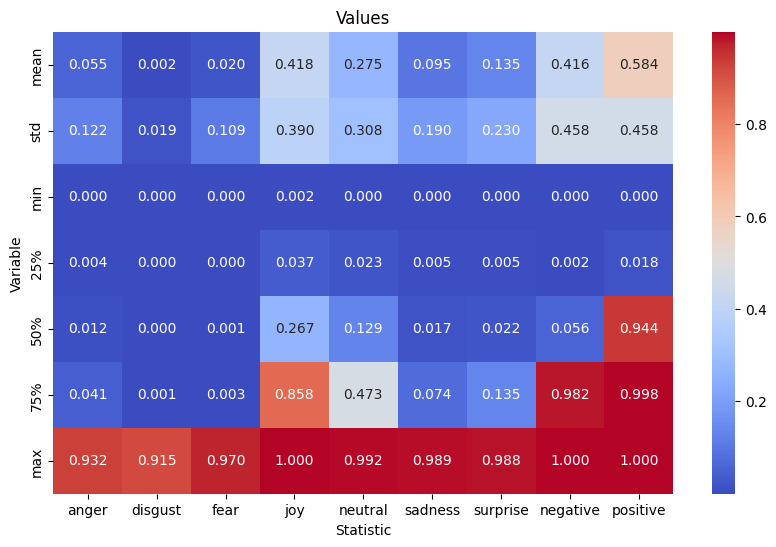

In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.describe().drop('count'), annot=True, fmt=".3f", cmap='coolwarm')
plt.xlabel('Statistic')
plt.ylabel('Variable')
plt.title('Values')
plt.show()

Znamy już wartości dot. rozkładów wszystkich cech z całości zbioru. Warto teraz skupić się na graficznym przedstawieniu rozkładów zmiennych wg klasyfikacji Ekmana ze względu na dominującą klasę. W tym celu stworzymy **wykresy pudełkowe**. Zadbamy o to, aby wyświetliły się w dwóch liniach (4 w pierwszej, 3 w drugiej), jak również o ich estetykę - ustawimy paletę kolorów oraz styl znaczników wartości odstających.

Widać wyraźnie, iż przede wszystkim od klasy zależy występowanie uczucia radości, co absolutnie nie może dziwić; rozkład próbek jest w ich wypadku mocno rozproszony, o czym świadczy długie pudełko obrazujące rozstęp międzykwartylowy i brak znaczników outlierów. Smutek, zdziwienie i złość są domeną klasy negatywnej; ciekawym jest, że również neutralne uczuciowo teksty są nieco częściej rozpoznawane przez model jako negatywne, choć te rozkłady są nieco podobne (dla klasy negatywnej bardziej rozproszony); może to wynikać z tego, jakie są uczucia współtowarzyszące neutralności. Potwierdza się zaś marginalność występowania wysokich wartości uczuć strachu i wstrętu, i to niezależnie od klasy; wykresy tych cech są w gruncie rzeczy złożone niemal w całości ze znaczników wartości odstających (przy czym te dot. wstrętu praktycznie nie ma wykazuje prawdopodobieństwa zaistnienia tego uczucia większego niż 0.2).
___
To visualize the distributions of variables based on Ekman classification and the dominant class, let's create **box plots**. We will arrange them in two rows (4 in the first row and 3 in the second) and pay attention to their aesthetics by setting the color palette and outlier marker style.

It is evident that the presence of joy heavily depends on the class, which is not surprising. The distribution of samples for joy is highly dispersed, as indicated by the long box plot representing the interquartile range and the absence of outlier markers. Sadness, surprise, and anger are predominantly associated with the negative class. Interestingly, even the emotionally neutral texts are sometimes classified more often as negative, although the distributions for neutral texts are somewhat similar (with a slightly higher dispersion for the negative class). This might be due to the accompanying emotions associated with neutrality. On the other hand, the low occurrence of high values for fear and disgust is confirmed, regardless of the class. The box plots for these emotions are mostly composed of outlier markers (with disgust having almost no instances with a probability higher than 0.2).

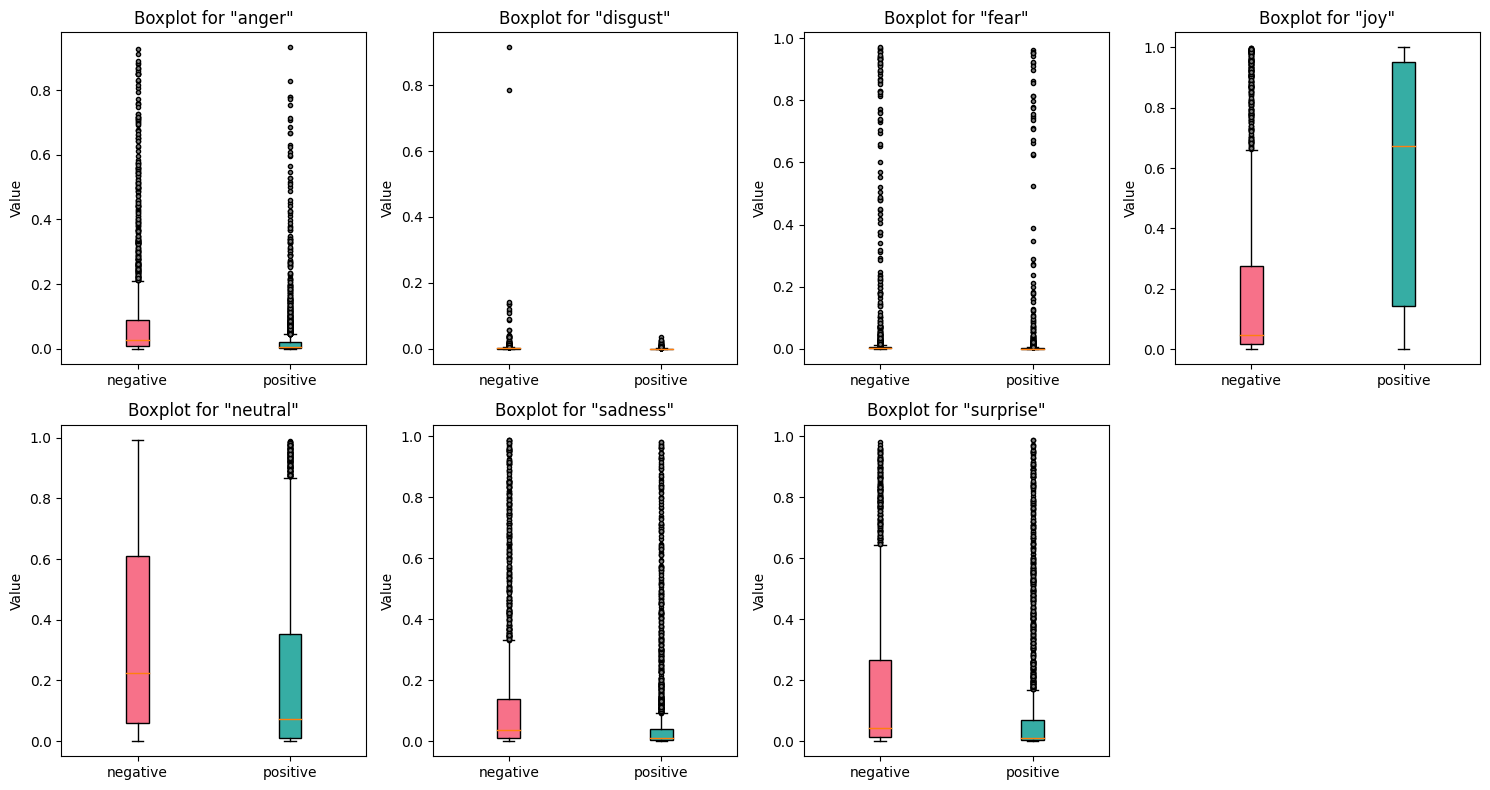

In [25]:
class_labels = df['labels_bin'].unique()

num_rows = 2
num_cols = int(np.ceil(len(emotions) / num_rows))

fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 8))
ax = ax.flatten()

colors = sns.color_palette("husl", n_colors=len(class_labels))

for i, emotion in enumerate(emotions):
    class_values = [df.loc[df['labels_bin'] == label, emotion] for label in class_labels]

    bp = ax[i].boxplot(class_values, labels=class_labels, patch_artist=True, showfliers=True)

    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    for flier in bp['fliers']:
        flier.set(marker='o', markersize=3, markeredgecolor='black', markerfacecolor='gray')

    ax[i].set_title(f'Boxplot for "{emotion}"')
    ax[i].set_ylabel('Value')

if len(emotions) < len(ax):
    for j in range(len(emotions), len(ax)):
        fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

Zobrazowanie rozkładów cech uzupełnią nam **wykresy skrzypcowe**. Violinploty w dużej części potwierdzają nam nasze wcześniejsze obserwacje, przy okazji nieco bardziej szczegółowo wyrysowując kształty rozkładów. Tak na dobrą sprawę niemal wszystkie wykresy dot. obu klas przyjmują kształt prawostronnie skośny. Rozkłady dot. złości, strachu, smutku i zdziwienia są mocno skupione wokół bardzo niskich wartości, a ze wzrostem wartości rekordów je przyjmujących jest stopniowo coraz mniej. Wykresy dot. wartości wstrętu potwierdzają, iż jest marginalnie występujące w tekstach uczucie. Ciekawymi są rozkłady: uczucia radości dla klasy pozytywnej - ma on bowiem tendencję do skupiania się w okolicach skrajnych wartości (bardzo małych i bardzo dużych) i jest mocno rozproszony w okolicach mediany, oraz neutralnego sentymentu dla klasy negatywnej - wartości powyżej mediany mają bardzo równomierną (niemal jednostajną) dystrubucję, a sama mediana znajduje się w punkcie wartości ok. dwukrotnie większej niż ta, w której skupienie jest największe.
___
The distributions of features can be further visualized using **violin plots**. Violin plots largely confirm our previous observations and provide a more detailed depiction of the distribution shapes. In general, most of the plots for both classes exhibit a right-skewed shape. The distributions for anger, fear, sadness, and surprise are highly concentrated around very low values, and as the values increase, their occurrence gradually decreases. The plots for disgust confirm that it is a minimally occurring emotion in the texts. Interesting patterns can be observed in the distributions of joy for the positive class, as it tends to concentrate around extreme values (very low and very high) and shows significant dispersion around the median. Similarly, for the negative class, the distributions of neutral sentiment exhibit a relatively uniform distribution for values above the median, while the median itself is located at a point approximately twice as large as the mode of the most concentrated values.

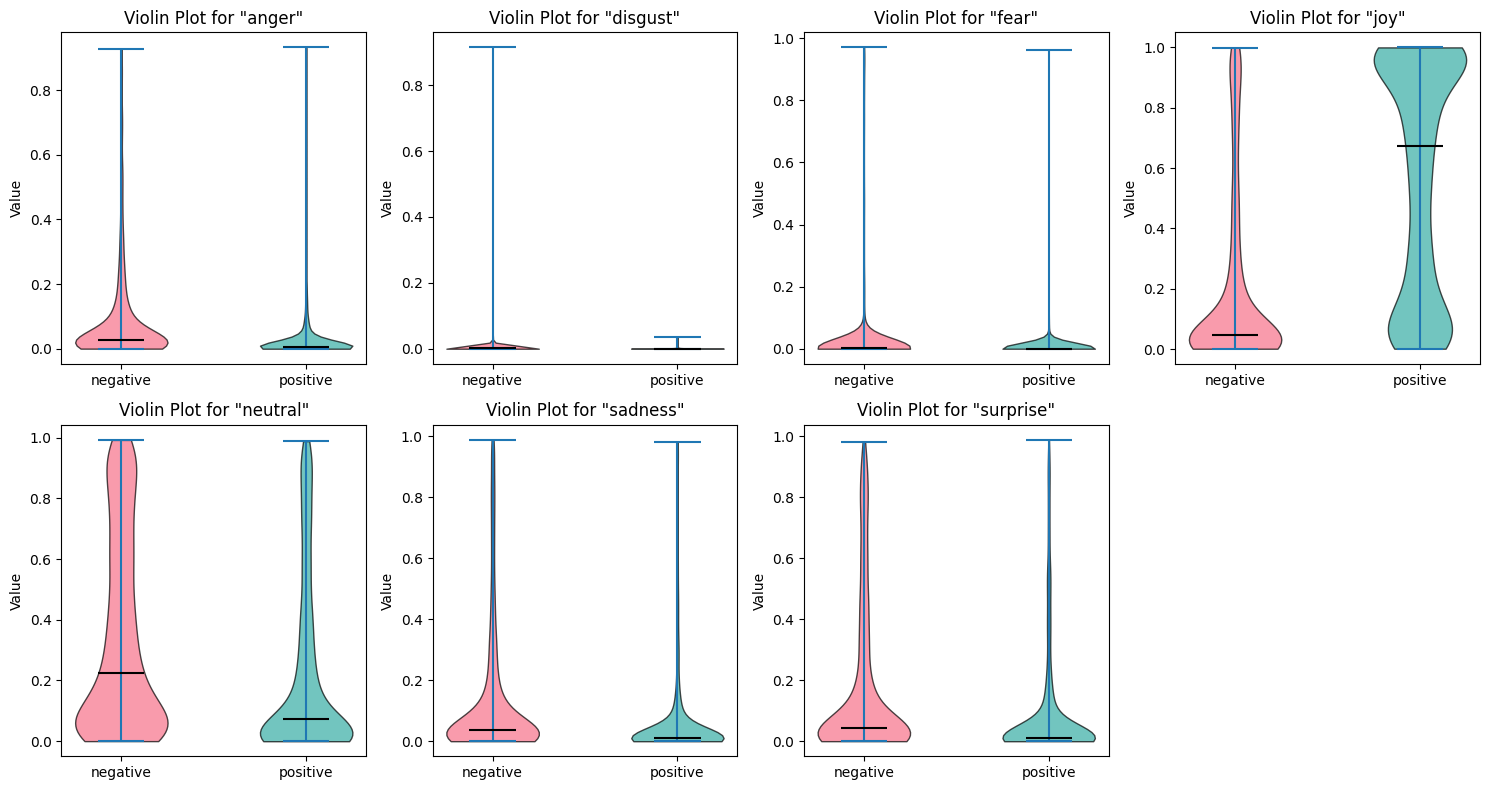

In [26]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 8))
ax = ax.flatten()

for i, emotion in enumerate(emotions):
    class_values = [df.loc[df['labels_bin'] == label, emotion] for label in class_labels]

    vp = ax[i].violinplot(class_values, showmedians=True)

    for pc, color in zip(vp['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
        
    vp['cmedians'].set_color('black')

    ax[i].set_title(f'Violin Plot for "{emotion}"')
    ax[i].set_ylabel('Value')

    ax[i].xaxis.set_tick_params(labelbottom=True)
    ax[i].set_xticks(np.arange(1, len(class_labels) + 1))
    ax[i].set_xticklabels(class_labels)

if len(emotions) < len(ax):
    for j in range(len(emotions), len(ax)):
        fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

Spróbujmy zobrazować, czy istnieje zależność między długością tekstów w znakach, a prawdopodobieństwem występowania któregokolwiek z uczuć. Okazuje się jednak, że w istocie stworzone **wykresy punktowe** pokazują, że żadna taka zależność nie występuje, a ich zawartość potwierdza nasze wcześniejsze obserwacje co do rozkładów danych. Może to wynikać z faktu, iż przedział liczbowy poszczególnych długości utworów jest wąski, a same wartości dość niewysokie.
___
By examining the relationship between the length of texts in characters and the probabilities of emotions, we can create **scatter plots**. However, it turns out that these plots show no clear relationship between the text length and the probabilities of emotions. The content of the plots confirms our previous observations regarding the data distributions. This lack of relationship may be due to the narrow numerical range of text lengths and the relatively low values they encompass.

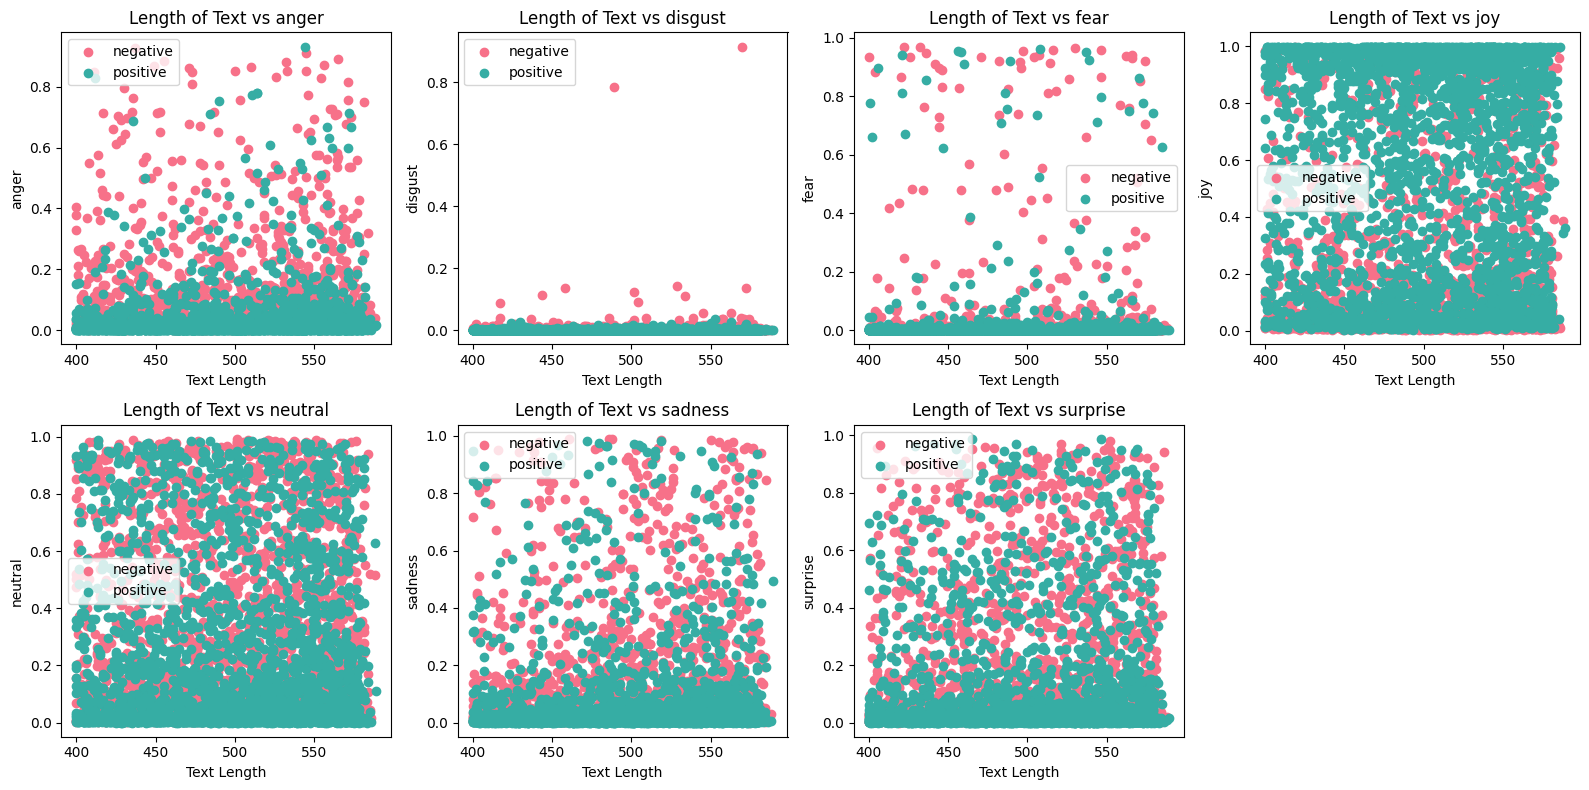

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(emotions):
    ax = axes[i]
    
    for j, class_label in enumerate(class_labels):
        class_data = df[df['labels_bin'] == class_label]
        ax.scatter(class_data['text'].str.len(), class_data[feature], label=class_label, color=colors[j])
    
    ax.set_title(f"Length of Text vs {feature}")
    ax.set_xlabel("Text Length")
    ax.set_ylabel(feature)
    ax.legend()
    
if len(emotions) < len(axes):
    for j in range(len(emotions), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Wykres słupkowy liczności klas potwierdza, iż pozytywny sentyment przeważa w naszej próbie tekstów piosenek.
___
The bar chart of class frequencies confirms that positive sentiment predominates in our sample of song lyrics.

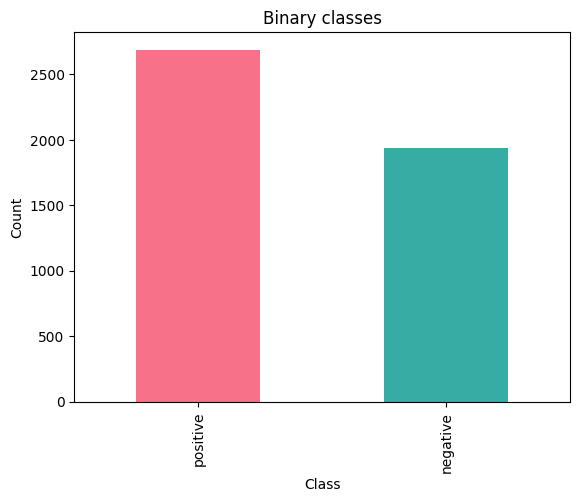

In [28]:
df['labels_bin'].value_counts().plot(kind='bar', color=colors)
plt.title('Binary classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Na sam koniec tego segmentu stworzymy macierz korelacji między cechami ciągłymi w formie heatmapy. Wynika z niej, że większość współczynników korelacji (w skali Pearsona) jest niska i reguły nie wychodzi poza zakres od -0.2 do 0.2. W tym gronie wyróżnia się szczególnie cecha "joy" - ma ona korelacje ujemne w zasadzie niemal z każdą inną cechą poza "positive" i z reguły są one na wyraźnie wyższym poziomie niż cała reszta korelacji (szczególnie wysoka korelacja ujemna z cechą "neutral" na poziomie -0.59). Co oczywiste, korelacje między wzajemnie wykluczającymi się cechami "positive" i "negative" sumują się do zera.
___
At the end of this segment, we will create a correlation matrix between the continuous features in the form of a heatmap. From the heatmap, we can observe that most of the correlation coefficients (in Pearson's scale) are low and do not exceed the range of -0.2 to 0.2. Among them, the "joy" feature stands out as it exhibits negative correlations with almost every other feature except "positive," and these correlations are generally higher than the rest (especially the strong negative correlation with the "neutral" feature at -0.59). As expected, the correlations between the mutually exclusive features "positive" and "negative" sum up to zero.

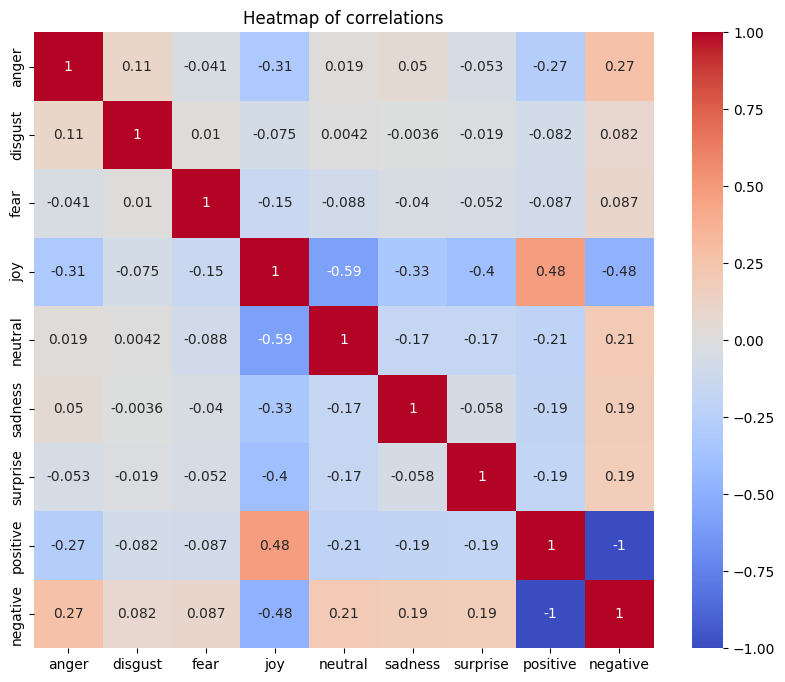

In [29]:
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise', 'positive', 'negative']

correlation_matrix = df[emotions].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap of correlations')
plt.show()

# Przygotowanie danych tekstowych do klasyfikacji/Text data preprocessing for classification.

Chyba najważniejszym celem, jaki postawiłem sobie w niniejszym projekcie, jest sprawdzenie, czy tradycyjne metody i algorytmy wykorzystywane do klasyfikacji tekstu są w stanie osiągnąć podobny poziom maszynowego rozumienia języka, co wstępnie wytrenowane modele z biblioteki Transformers. Dlatego też rozkład jazdy na ostatnie dwie części to najpierw przygotowanie tekstu, aby był gotów do przetwarzania, a następnie klasyfikacja za pomocą czterech wybranych przeze mnie modeli.

Rozpoczynamy jednak od wydobycia z ramki danych **df** naszych zestawów cech niezależnych i zależnych. Zbiorem cech **niezależnych** będzie kolumna **"text"**, zaś cech zależnych - kolumna **"labels_bin"**.
____
One of the main goals I set for myself in this project is to determine whether traditional methods and algorithms used for text classification can achieve a similar level of natural language understanding as pre-trained models from the Transformers library. Therefore, the roadmap for the last two parts consists of preparing the text for processing and then performing classification using four models that I have selected.

However, we will start by extracting the **independent** and **dependent** features from the **df** DataFrame. The set of **independent features** will be the **"text"** column, while the set of **dependent features** will be the **"labels_bin"** column.

In [30]:
X = df['text']
y = df['labels_bin']

In [31]:
X[0]

"Well, you hoot and you holler and you make me mad   And I've always been under your heel   Holy christ what a lousy deal   Now I'm sick and tired of your tedious ways   And I ain't gonna take it no more   Oh no no - walkin' out that door      Burning my bridges, cutting my tie   Once again I wanna look into the eye   Being myself   Counting my pride   No un-right neighbour's gonna take me for a ride   Burning my bridges   Moving at last   Girl I'm leaving and I'm burying the past   Gonna have peace now   You can be free   No one here will make a sucker out of me  "

Przystępujemy do standaryzacji tekstu. Najpierw zastosujemy funkcję **lower**, aby zamienić wszystkie litery w tekście na małe.
___
We will proceed with text standardization. First, we will apply the **lower** function to convert all letters in the text to lowercase.

In [32]:
X = X.str.lower()

Kontrakcje, jakkolwiek przydatne i upraszczające pisownię w języku angielskim, są mało wygodne w komputerowym przetwarzaniu języka. Pozbędziemy się ich za pomocą funkcji **expand_contractions**, która posłuży rozwinięciu najbardziej powszechnych z nich.
___
Contractions, while useful and simplifying in English language writing, can be less convenient for computational language processing. We will remove them using the **expand_contractions** function, which will expand the most common contractions.

In [33]:
contractions_dict = {"ain't": "are not","'s":" is","n't": " not",
                    "'re": " are", "'m": " am", "'ve": " have",
                    "gonna": "going to", "wanna": "want to",
                    "'ll": " will"}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text, contractions_dict = contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

X = X.apply(lambda x: expand_contractions(x))

Z biblioteki **NLTK** pobierzmy pakiety, które pozwolą nam na **tokenizację** (**"punkt"**), usunięcie tzw. **stopwords** (**"stopwords"**), oraz zastosowanie **lematyzacji** (**"wordnet"** oraz **"omw-1.4"**).
___
Let's download the packages from the **NLTK** library that will allow us to perform **tokenization** (**"punkt"**), remove **stopwords** (**"stopwords"**), and apply **lemmatization** (**"wordnet"** and **"omw-1.4"**).

In [34]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JAKUB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JAKUB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JAKUB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\JAKUB\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Stopwords** to słowa, które są powszechne w języku naturalnym, ale same w sobie indyferentne z semantycznego punktu widzenia (wszelkiego rodzaju przyimki etc.). Ich usunięcie jest powszechną techniką w NLP. My dokonamy tego przy pomocy zdefiniowanej na potrzeby projektu funkcji **remove_stopwords**.
___
**Stopwords** are common words in natural language that are semantically neutral and often do not carry significant meaning (e.g., prepositions, articles, etc.). Removing them is a common technique in NLP. We will get rid of stopwords using a custom function called **remove_stopwords** that we defined for this project.

In [35]:
stop_words = set(stopwords.words('english'))

In [36]:
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

X = X.apply(lambda x: remove_stopwords(x))

Doskonale widać, że pozbycie się stopwords znacznie uszczupliło zawartość pierwszego rekordu.
___
It is clear that removing stopwords has significantly reduced the content of the first record.

In [37]:
X[0]

"well, hoot holler make mad always heel holy christ lousy deal sick tired tedious ways going take oh - walkin' door burning bridges, cutting tie want look eye counting pride un-right neighbour going take ride burning bridges moving last girl leaving burying past going peace free one make sucker"

Nie zaszkodzi też pozbyć się znaków interpunkcyjnych z tekstów.
___
It's also a good idea to remove punctuation marks from the texts.

In [38]:
X = X.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

In [39]:
for str in X[0:4]:
    print(len(str))

289
311
228
292


Kolejny krok to **lematyzacja**. Jest to jeden z dwóch sposobów na ujednolicenie zapisów słów, polegający na przetworzeniu ich do podstawowej formy słownikowej, zwanej lematem. Drugim sposobem jest tzw. **stemming**, polegający wydobycie z wyrazu jego rdzenia (stemu), jednakże jest on rzadziej stosowany ze względu na mniejszą poprawę skuteczności, niezachowanie poprawności semantycznej i słabszą interpretowalność.
___
The next step is **lemmatization**. It is one of the two ways to standardize word forms, by transforming them into their base dictionary form, known as a lemma. The other method is called **stemming**, which involves extracting the root form (stem) of a word. However, stemming is less commonly used due to its lower effectiveness in improving accuracy, lack of semantic correctness, and reduced interpretability.

In [40]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

X = X.apply(lambda x: lemmatize_text(x))

Lematyzacja nieznacznie skraca część rekordów spośród czterech pierwszych, które przyjęliśmy do obserwacji.
___
Lemmatization slightly reduces the length of some records among the first four that we have taken for observation.

In [41]:
for str in X[0:4]:
    print(len(str))

285
308
228
287


Na samym końcu stosujemy **tokenizację** - jest to proces dzielenia tekstu na mniejsze jednostki (**tokeny**), najczęściej pojedyncze słowa, znaki interpunkcyjne (których jednak się zawczasu pozbyliśmy), co umożliwia dalszą analizę tekstu.
___
Finally, we apply **tokenization**, which is the process of dividing the text into smaller units called **tokens**, usually individual words or punctuation marks (which we have already removed), enabling further analysis of the text.

In [42]:
X_tokenized = X.apply(nltk.word_tokenize)

In [43]:
X_tokenized[0]

['well',
 'hoot',
 'holler',
 'make',
 'mad',
 'always',
 'heel',
 'holy',
 'christ',
 'lousy',
 'deal',
 'sick',
 'tired',
 'tedious',
 'way',
 'going',
 'take',
 'oh',
 'walkin',
 'door',
 'burning',
 'bridge',
 'cutting',
 'tie',
 'want',
 'look',
 'eye',
 'counting',
 'pride',
 'unright',
 'neighbour',
 'going',
 'take',
 'ride',
 'burning',
 'bridge',
 'moving',
 'last',
 'girl',
 'leaving',
 'burying',
 'past',
 'going',
 'peace',
 'free',
 'one',
 'make',
 'sucker']

Zanim przystąpimy do treningu i ewaluacji modelu, za pomocą **chmury słów** sprawdźmy 20 najczęściej występujących w tekście wyrazów (im większy napis, tym częstszy wyraz). Nie ma tu niespodzianek - czołowe miejsca zajmują słowa odnoszące się do elementarnych uczuć i aktywności.
___
Before we proceed to train and evaluate the model, let's use a **word cloud** to visualize the 20 most frequently occurring words in the text (the larger the word, the more frequent it is). There are no surprises here - the top positions are occupied by words related to basic emotions and activities.

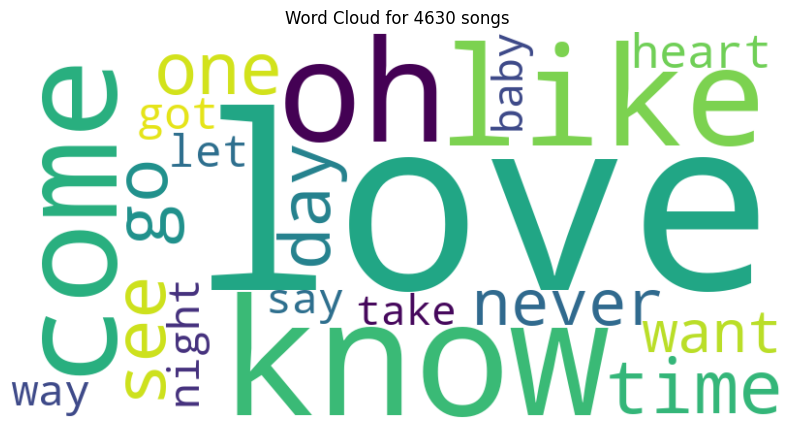

In [44]:
wordcloud_text = ' '.join([' '.join(text) for text in X_tokenized])
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      stopwords=stop_words, max_words=20, collocations=False).generate(wordcloud_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud for {len(X_tokenized)} songs')
plt.show()

Absolutną podstawą uczenia maszynowego jest podział zbiorów na **treningowy i testowy**. Nie inaczej będzie w tym wypadku. Zgodnie z przyjętą konwencją wielkość zbioru testowego ustalamy na 1/5 całości rekordów.
___
The fundamental principle of machine learning is to divide the dataset into **training and testing sets**, and the same applies in this case. Following the convention, we will set the size of the testing set to be 1/5 of the total number of records.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_tokenized, y, test_size=0.2, random_state=42)

In [46]:
print(f'X_train length: {len(X_train)}')
print(f'X_test length: {len(X_test)}')
print(f'y_train length: {len(y_train)}')
print(f'y_test length: {len(y_test)}')

X_train length: 3704
X_test length: 926
y_train length: 3704
y_test length: 926


# Klasyfikacja tekstu przy użyciu tradycyjnych algorytmów/Text classification with traditional algorithms.

Tę część rozpoczniemy od zdefiniowania czterech modelu i ich parametrów do strojenia:
- **"MultinomialNB"**: Model klasyfikacji Naive Bayes z zastosowaniem rozkładu wielomianowego.
- **"BernoulliNB"**: Model klasyfikacji Naive Bayes z zastosowaniem rozkładu Bernoulliego.
- **"DecisionTree"**: Model klasyfikacji drzewa decyzyjnego.
- **"KNearestNeighbors"**: Model klasyfikacji k-najbliższych sąsiadów.

Każdy model jest zdefiniowany jako potok (pipeline) składający się z dwóch kroków: **TFIDFVectorizer** (do przekształcenia tekstu na wektory cech TF-IDF) i konkretnego klasyfikatora.

Dla każdego modelu został zdefiniowany słownik zawierający różne kombinacje parametrów, które zostaną przetestowane podczas procesu strojenia:
- dla modelu "MultinomialNB": **"MultinomialNB__alpha"**: parametr wygładzania Laplace'a (ma zapobiegać sytuacjom, w których prawdopodobieństwo dla danej cechy byłoby równe zero, co mogłoby doprowadzić do problemów z obliczeniami),
- dla modelu "BernoulliNB": **"BernoulliNB__alpha"** - parametr wygładzania Laplace'a - i **"BernoulliNB__binarize"** - parametr wysokości progu binarizacji, powyżej którego cechy były traktowane jako binarne,
- dla modelu "DecisionTree": **"DecisionTree__class_weight"** - waga klas w modelu drzewa decyzyjnego - i **"DecisionTree__max_depth"**: maksymalna głębokość drzewa decyzyjnego,
- dla modelu "KNearestNeighbors": **"KNearestNeighbors__n_neighbors"** - liczba sąsiadów branych pod uwagę w modelu k-najbliższych sąsiadów i **"KNearestNeighbors__weights"** - waga używana w modelu k-najbliższych sąsiadów (równa dla wszystkich sąsiadów lub odwrotnie proporcjonalna do odległości).

Ponadto dla każdego z modeli został wskazany **"TFIDF__ngram_range"**, tj. zakres n-gramów (sekwencji słów) używanych przez TF-IDFVectorizer (1 - unigramy lub 2 - bigramy).
___
This part will begin with the definition of four models and their tuning parameters:
- **"MultinomialNB"**: Naive Bayes classification model using the multinomial distribution.
- **"BernoulliNB"**: Naive Bayes classification model using the Bernoulli distribution.
- **"DecisionTree"**: Decision tree classification model.
- **"KNearestNeighbors"**: K-nearest neighbors classification model.

Each model is defined as a pipeline consisting of two steps: **TFIDFVectorizer** (to transform text into TF-IDF feature vectors) and a specific classifier.

For each model, a dictionary is defined that contains different combinations of parameters to be tested during the tuning process:
- For the "MultinomialNB" model: **"MultinomialNB__alpha"**: Laplace smoothing parameter (to prevent situations where the probability for a particular feature is zero, which could lead to computational issues).
- For the "BernoulliNB" model: **"BernoulliNB__alpha"**: Laplace smoothing parameter, and **"BernoulliNB__binarize"**: binarization threshold above which features are treated as binary.
- For the "DecisionTree" model: **"DecisionTree__class_weight"**: class weights in the decision tree model, and **"DecisionTree__max_depth"**: maximum depth of the decision tree.
- For the "KNearestNeighbors" model: **"KNearestNeighbors__n_neighbors"**: number of neighbors considered in the k-nearest neighbors model, and **"KNearestNeighbors__weights"**: weight used in the k-nearest neighbors model (uniform or distance-based).

In addition, each model specifies **"TFIDF__ngram_range"**, which determines the range of n-grams (word sequences) used by the TF-IDFVectorizer (1 for unigrams or 2 for bigrams).

In [47]:
models = [
    ("MultinomialNB", Pipeline([("TFIDF", TfidfVectorizer()), ("MultinomialNB", MultinomialNB())])),
    ("BernoulliNB", Pipeline([("TFIDF", TfidfVectorizer()), ("BernoulliNB", BernoulliNB())])),
    ("DecisionTree", Pipeline([("TFIDF", TfidfVectorizer()), ("DecisionTree", DecisionTreeClassifier())])),
    ("KNearestNeighbors", Pipeline([("TFIDF", TfidfVectorizer()), ("KNearestNeighbors", KNeighborsClassifier())]))
]


param_grids = {
    "MultinomialNB": {
        "TFIDF__ngram_range": [(1, 1), (1, 2)],
        "MultinomialNB__alpha": [0.1, 0.5, 1.0]
    },
    "BernoulliNB": {
        "TFIDF__ngram_range": [(1, 1), (1, 2)],
        "BernoulliNB__alpha": [0.1, 0.5, 1.0],
        "BernoulliNB__binarize": [0.0, 0.5, 1.0]
    },
    "DecisionTree": {
        "TFIDF__ngram_range": [(1, 1), (1, 2)],
        "DecisionTree__class_weight": [None, 'balanced'],
        "DecisionTree__max_depth": [None, 5, 10]
    },
    "KNearestNeighbors": {
        "TFIDF__ngram_range": [(1, 1), (1, 2)],
        "KNearestNeighbors__n_neighbors": [3, 5],
        "KNearestNeighbors__weights": ['uniform', 'distance']
    }
}

Wyniki poszczególnych modeli będziemy zapisywać w ramce danych **results_df**, która pozwoli nam na szybkie ich porównanie.
___
The results of each model will be stored in a DataFrame called **results_df**, which will allow us to easily compare them.

In [48]:
results_df = pd.DataFrame(columns=["Model", "Best Parameters", "Training Accuracy", "Test Accuracy", "Training F1 Score", "Test F1 Score"])

Przechodzimy do treningu modeli. Odpowiedniej kombinacji parametrów szukać będziemy przy użyciu **GridSearchCV**, metody umożliwiającej strojenie hiperparametrów poprzez użycie wszystkich kombinacji tychże dla danego modelu i przeprowadzenie walidacji krzyżowej. Oprócz dostrajania, kroswalidacji, treningu i predykcji sprawdzać będziemy metryki modeli (dla obu zbiorów) przy pomocy metody **classification_report**, rysować macierze pomyłek dla zbioru testowego w formie wykresów (**ConfusionMatrixDisplay**) oraz uzupełniać stosownymi metrykami naszą ramkę danych results_df. Dla lepszej kontroli tego, jak szybko trenowane są modele w poszczególnych iteracjach, zastosujemy ponownie funkcję tqdm.
___
We will now proceed with training the models. We will use **GridSearchCV**, a method that allows us to tune hyperparameters by exhaustively searching all possible combinations and performing cross-validation. In addition to tuning, cross-validation, training, and prediction, we will evaluate the models using the **classification_report** method to check the metrics for both the training and test sets. We will also plot confusion matrices for the test set using **ConfusionMatrixDisplay** and update the results_df DataFrame with the relevant metrics. To track the training progress in each iteration, we will once again use the tqdm function.

  0%|          | 0/4 [00:00<?, ?it/s]

Training and evaluating MultinomialNB...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'MultinomialNB__alpha': 0.1, 'TFIDF__ngram_range': (1, 1)}
Training classification report:               precision    recall  f1-score   support

    negative       0.97      0.83      0.90      1549
    positive       0.89      0.98      0.94      2155

    accuracy                           0.92      3704
   macro avg       0.93      0.91      0.92      3704
weighted avg       0.93      0.92      0.92      3704

Test classification report:               precision    recall  f1-score   support

    negative       0.74      0.54      0.63       393
    positive       0.72      0.86      0.78       533

    accuracy                           0.72       926
   macro avg       0.73      0.70      0.70       926
weighted avg       0.73      0.72      0.72       926

Training F1 Score: 0.9167037056793451
Test F1 Score: 0.7042559933469184




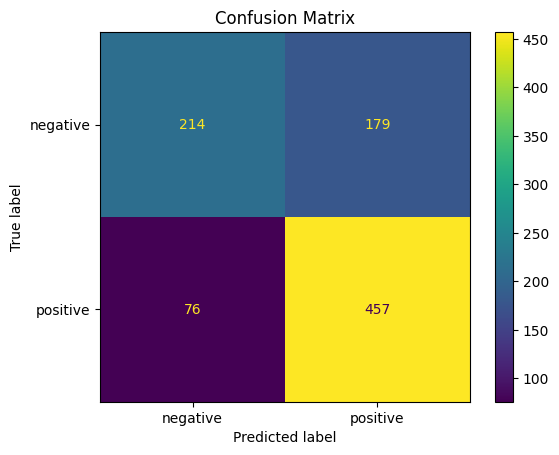

 25%|██▌       | 1/4 [00:16<00:49, 16.48s/it]

Training and evaluating BernoulliNB...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'BernoulliNB__alpha': 0.5, 'BernoulliNB__binarize': 0.0, 'TFIDF__ngram_range': (1, 1)}
Training classification report:               precision    recall  f1-score   support

    negative       0.93      0.85      0.88      1549
    positive       0.90      0.95      0.92      2155

    accuracy                           0.91      3704
   macro avg       0.91      0.90      0.90      3704
weighted avg       0.91      0.91      0.91      3704

Test classification report:               precision    recall  f1-score   support

    negative       0.70      0.63      0.66       393
    positive       0.74      0.80      0.77       533

    accuracy                           0.73       926
   macro avg       0.72      0.72      0.72       926
weighted avg       0.73      0.73      0.73       926

Training F1 Score: 0.9035150533124304
Test F1 Score: 0.7179251614406539




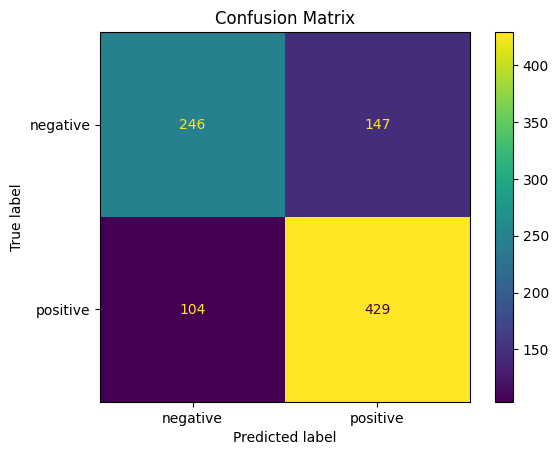

 50%|█████     | 2/4 [00:45<00:48, 24.07s/it]

Training and evaluating DecisionTree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'DecisionTree__class_weight': 'balanced', 'DecisionTree__max_depth': 10, 'TFIDF__ngram_range': (1, 2)}
Training classification report:               precision    recall  f1-score   support

    negative       0.64      0.84      0.73      1549
    positive       0.85      0.67      0.75      2155

    accuracy                           0.74      3704
   macro avg       0.75      0.75      0.74      3704
weighted avg       0.77      0.74      0.74      3704

Test classification report:               precision    recall  f1-score   support

    negative       0.57      0.71      0.63       393
    positive       0.74      0.61      0.67       533

    accuracy                           0.65       926
   macro avg       0.66      0.66      0.65       926
weighted avg       0.67      0.65      0.65       926

Training F1 Score: 0.7385938488797963
Test F1 Score: 0.650286986

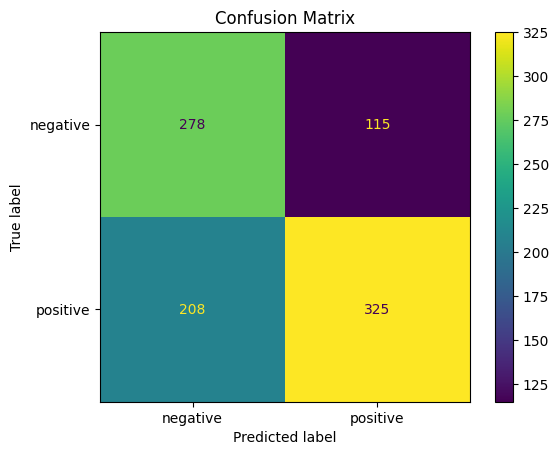

 75%|███████▌  | 3/4 [02:35<01:03, 63.02s/it]

Training and evaluating KNearestNeighbors...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'KNearestNeighbors__n_neighbors': 3, 'KNearestNeighbors__weights': 'uniform', 'TFIDF__ngram_range': (1, 1)}
Training classification report:               precision    recall  f1-score   support

    negative       0.84      0.69      0.76      1549
    positive       0.80      0.90      0.85      2155

    accuracy                           0.81      3704
   macro avg       0.82      0.80      0.80      3704
weighted avg       0.82      0.81      0.81      3704

Test classification report:               precision    recall  f1-score   support

    negative       0.62      0.44      0.51       393
    positive       0.66      0.80      0.72       533

    accuracy                           0.65       926
   macro avg       0.64      0.62      0.62       926
weighted avg       0.64      0.65      0.63       926

Training F1 Score: 0.8033032462831147
Test F1 Score: 0.

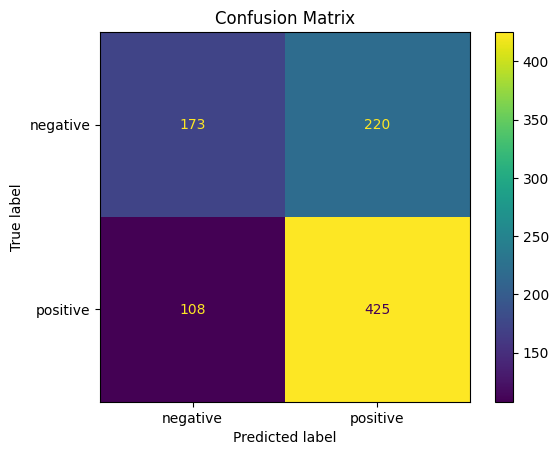

100%|██████████| 4/4 [02:56<00:00, 44.09s/it]

In [49]:
for name, model in tqdm(models):
    print(f"Training and evaluating {name}...")
    param_grid = param_grids.get(name, {})
    
    grid_search = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train.apply(' '.join), y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    y_train_pred = best_model.predict(X_train.apply(' '.join))
    train_classification_rep = classification_report(y_train, y_train_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1_score = f1_score(y_train, y_train_pred, average="macro")
    
    y_test_pred = best_model.predict(X_test.apply(' '.join))
    test_classification_rep = classification_report(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1_score = f1_score(y_test, y_test_pred, average="macro")
    
    results_df = results_df.append({
        "Model": name,
        "Best Parameters": best_params,
        "Training Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Training F1 Score": train_f1_score,
        "Test F1 Score": test_f1_score,
    }, ignore_index=True)
    
    print(f"Best parameters: {best_params}")
    print(f"Training classification report: {train_classification_rep}")
    print(f"Test classification report: {test_classification_rep}")
    print(f"Training F1 Score: {train_f1_score}")
    print(f"Test F1 Score: {test_f1_score}")
    print("\n")
    
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()
    print("=" * 50)

Nie można powiedzieć, żeby metryki tych modeli były jakieś drastycznie złe - drzewo decyzyjne nieźle przewidywało klasę mniejszościową (w tym modelu, o ironio, nazwaną "Negative" i umiejscowioną w górnym rzędzie macierzy), solidnie w klasie większościowej wypadł MultinomialNB, a przyzwoitym trade-offem okazał się być BernoulliNB. Tym niemniej w porównaniu z modelem, który jest w stanie rozumieć tekst niemal tak dobrze, jak człowiek, a jego implementacja do większej struktury danych może się sprowadzić do dwóch linijek kodu, wypadają one korzystniej jedynie pod względem szybkości obliczeń.

Na sam koniec wyświetlmy ramkę danych result_df - tym razem, dzięki zastosowaniu parametru **cmap**, w bardziej atrakcyjnej wizualnie formie. Najlepsze metryki odnotowują modele Naive Bayes z dokładnością i F1 score na poziomie ponad 0.7 na zbiorze testowym. Nie da się jednak nie zauważyć, iż modele te nie cechują się szczególnie wysoką zdolnością do uogólniania - spadek metryk względem zbioru treningowego jest bardzo wyraźny. Tym niemniej deklasują one "konkurencję".
___
One cannot say that the metrics of these models are drastically poor. The decision tree performed reasonably well in predicting the minority class (ironically labeled "Negative" in this model and located in the upper row of the confusion matrix). MultinomialNB performed solidly in the majority class, and BernoulliNB showed a decent trade-off. However, when compared to a model that can understand text almost as well as a human and can be implemented with just a few lines of code, these models only outperform in terms of computational speed.

Finally, let's display the results_df DataFrame again, but this time, using the **cmap** parameter to make it more visually appealing. The Naive Bayes models achieved the best metrics, with an accuracy and F1 score of over 0.7 on the test set. However, it is impossible not to notice that these models do not exhibit a particularly high ability to generalize, as there is a significant drop in metrics compared to the training set. Nevertheless, they outperform the "competition".

In [50]:
print("Results:")
results_df.style.background_gradient(cmap='YlGnBu')

Results:


,Model,Best Parameters,Training Accuracy,Test Accuracy,Training F1 Score,Test F1 Score
0,MultinomialNB,"{'MultinomialNB__alpha': 0.1, 'TFIDF__ngram_range': (1, 1)}",0.920896,0.724622,0.916704,0.704256
1,BernoulliNB,"{'BernoulliNB__alpha': 0.5, 'BernoulliNB__binarize': 0.0, 'TFIDF__ngram_range': (1, 1)}",0.907397,0.728942,0.903515,0.717925
2,DecisionTree,"{'DecisionTree__class_weight': 'balanced', 'DecisionTree__max_depth': 10, 'TFIDF__ngram_range': (1, 2)}",0.738931,0.651188,0.738594,0.650287
3,KNearestNeighbors,"{'KNearestNeighbors__n_neighbors': 3, 'KNearestNeighbors__weights': 'uniform', 'TFIDF__ngram_range': (1, 1)}",0.814255,0.645788,0.803303,0.617458


# Podsumowanie/Summary.

Nie bez powodu opracowanie BERT uznawany jest za jedno z najbardziej rewolucyjnych dokonań uczenia maszynowego. W tym projekcie pełnił on jedynie rolę pomocniczą - przypisał do naszych danych tekstowych cechy ciągłe i dyskretne, pozwalając na wdrożenie tradycyjnych metod oraz wizualizację, a następnie analizę danych.

Osiągnięcie przez BERT poziomu człowieka w rozumieniu słowa pisanego i całe spektrum zastosowań do różnych zadań (także np. **question answering** czy tzw. **zero shot classification**) musi budzić zachwyt - tym większy, że jego implementacja, choć całkowicie niewymagająca, pozwala nam na ominięcie wielu żmudnych etapów klasycznego NLP. Za tą prostotą stoi jednak potężna i wytrenowana na ogromnej ilości rekordów architektura sieci neuronowych. Kolejny już raz okazuje się, że łatwość korzystania z rozwiązania wynika z czasu i wysiłku poświęconego na jego opracowanie.

Co do samych tekstów piosenek - nie zapominajmy, iż tekst jest wyłącznie jednym elementów piosenki. To, jak ją postrzegamy - czy jako smutną, czy wesołą, czy wyrażającą strach, zdziwienie czy wstręt - zależy nie tylko od tego, co jest zaśpiewane, ale i od tego, jak coś jest zaśpiewane i w jakim akompaniamencie. Dlatego też, wbrew temu, co pisałem, muzyka to nie tylko matematyka. To przede wszystkim emocje wynikające z połączenia dźwięków i przesłania płynącego z jej lirycznej warstwy. I z tą refleksją Was niniejszym zostawiam.
___
Not without reason, the development of BERT is considered one of the most revolutionary achievements in machine learning. In this project, it served as an auxiliary tool, assigning continuous and discrete features to our textual data, enabling the implementation of traditional methods, as well as visualization and subsequent data analysis.

The fact that BERT has achieved human-level understanding of written words and offers a wide range of applications for various tasks, including **question answering** and **zero-shot classification**, is truly remarkable. What's even more impressive is that its implementation, although completely seamless, allows us to bypass many laborious steps in classical NLP. However, behind this simplicity lies a powerful architecture of neural networks, trained on a massive amount of data. Once again, it becomes evident that the ease of using such a solution is the result of the time and effort invested in its development.

Regarding the song lyrics themselves, let's not forget that the lyrics are just one element of a song. How we perceive a song, whether as sad, happy, expressing fear, surprise, or disgust, depends not only on what is sung but also on how it is sung and the accompanying music. Therefore, contrary to what I wrote earlier, music is not merely mathematics. It is primarily about emotions that arise from the combination of sounds and the message conveyed through its lyrical layer. And with this reflection, I leave you.